Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 7

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=7
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=4 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
#
drop_n_dataset_days=520
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
245                                           NaN             Timor-Leste   
246                                           NaN                    Togo   
247                                           NaN     Trinidad and Tobago   
248                                           NaN                 Tunisia   
249                                           NaN                  Turkey   
250                                           NaN           United States   
251                                           NaN                  Uganda   
252                                           NaN                 Ukraine   
253                                           NaN    United Arab Emirates   
254                                      Anguilla          United Kingdom   
255                                       Bermuda          United Kingdom   
256                        British Virgin Islands          United Kingdom   
257                                Cayman Islands          United Kingdom   
258                               Channel Islands          United Kingdom   
259                   Falkland Islands (Malvinas)          United Kingdom   
260                                     Gibraltar          United Kingdom   
261                                   Isle of Man          United Kingdom   
262                                    Montserrat          United Kingdom   
263  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
264                      Turks and Caicos Islands          United Kingdom   
265                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
251                                           NaN             Timor-Leste   
252                                           NaN                    Togo   
253                                           NaN     Trinidad and Tobago   
254                                           NaN                 Tunisia   
255                                           NaN                  Turkey   
256                                           NaN           United States   
257                                           NaN                  Uganda   
258                                           NaN                 Ukraine   
259                                           NaN    United Arab Emirates   
260                                      Anguilla          United Kingdom   
261                                       Bermuda          United Kingdom   
262                        British Virgin Islands          United Kingdom   
263                                Cayman Islands          United Kingdom   
264                               Channel Islands          United Kingdom   
265                   Falkland Islands (Malvinas)          United Kingdom   
266                                     Gibraltar          United Kingdom   
267                                   Isle of Man          United Kingdom   
268                                    Montserrat          United Kingdom   
269  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
270                      Turks and Caicos Islands          United Kingdom   
271                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN  Marshall Islands   7.131500  171.184500        0        0   
186            NaN        Mauritania  21.007900  -10.940800        0        0   
187            NaN         Mauritius -20.348404   57.552152        0        0   
188            NaN            Mexico  23.634500 -102.552800        0        0   
189            NaN        Micronesia   7.425600  150.550800        0        0   
190            NaN           Moldova  47.411600   28.369900        0        0   
191            NaN            Monaco  43.733300    7.416700        0        0   
192            NaN          Mongolia  46.862500  103.846700        0        0   
193            NaN        Montenegro  42.708678   19.374390        0        0   
194            NaN           Morocco  31.791700   -7.092600        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  4/22/21  4/23/21  4/24/21  \
185        0        0        0        0  ...        0        0        0   
186        0        0        0        0  ...      454      454      454   
187        0        0        0        0  ...       16       16       16   
188        0        0        0        0  ...   214095   214504   214853   
189        0        0        0        0  ...        0        0        0   
190        0        0        0        0  ...     5668     5691     5709   
191        0        0        0        0  ...       31       31       31   
192        0        0        0        0  ...       61       74       78   
193        0        0        0        0  ...     1451     1457     1463   
194        0        0        0        0  ...     8976     8983     8988   

     4/25/21  4/26/21  4/27/21  4/28/21  4/29/21   Population   \
185        0        0        0        0        0           NaN   
186      454      455      455      455      455     4,649,658   
187       16       17       17       17       17           NaN   
188   214947   215113   215547   215918   216447   128,640,794   
189        0        0        0        0        0           NaN   
190     5730     5745     5762     5780     5795     4,035,942   
191       32       32       32       32       32        39,183   
192       80       80       88       97      110     3,278,290   
193     1465     1473     1478     1485     1492       622 500   
194     8992     8999     9005     9015     9020    36,817,128   

                   region  
185  Marshall Islands_nan  
186        Mauritania_nan  
187         Mauritius_nan  
188            Mexico_nan  
189        Micronesia_nan  
190           Moldova_nan  
191            Monaco_nan  
192          Mongolia_nan  
193        Montenegro_nan  
194           Morocco_nan  

[10 rows x 470 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN       Mongolia  46.862500  103.84670   
176                               NaN     Montenegro  42.708678   19.37439   
177                               NaN        Morocco  31.791700   -7.09260   
178                               NaN     Mozambique -18.665700   35.52960   
179                               NaN        Namibia -22.957600   18.49040   
180                               NaN          Nepal  28.166700   84.25000   
181                             Aruba    Netherlands  12.521100  -69.96830   
182  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
183                           Curacao    Netherlands  12.169600  -68.99000   
184                      Sint Maarten    Netherlands  18.042500  -63.05480   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  4/22/21  \
175        0        0        0        0        0        0  ...    13772   
176        0        0        0        0        0        0  ...    91905   
177        0        0        0        0        0        0  ...   493873   
178        0        0        0        0        0        0  ...    62394   
179        0        0        0        0        0        0  ...    45136   
180        0        0        0        0        0        0  ...   276345   
181        0        0        0        0        0        0  ...    10024   
182        0        0        0        0        0        0  ...      180   
183        0        0        0        0        0        0  ...    10011   
184        0        0        0        0        0        0  ...     2167   

     4/23/21  4/24/21  4/25/21  4/26/21  4/27/21  4/28/21  4/29/21  \
175    14745    15403    16815    16815    17543    18033    19642   
176    92142    92377    92609    92756    92975    93188    93369   
177   494415   494872   495262   495408   496031   496583   497105   
178    62408    62452    62501    62927    64448    64541    64541   
179    45278    45334    45558    45642    45740    45909    45909   
180   276755   277123   277573   277951   278506   279279   280167   
181    10069    10121    10169    10211    10245    10298    10336   
182      180      180      180      180      180      180     1465   
183    10291    10494    10801    10916    11339    11339    11543   
184     2174     2175     2175     2181     2181     2184     2184   

      Population                                         region  
175     3,278,290                                  Mongolia_nan  
176       622 500                                Montenegro_nan  
177    36,817,128                                   Morocco_nan  
178    31,542,919                                Mozambique_nan  
179     2,540,905                                   Namibia_nan  
180    29,300,000                                     Nepal_nan  
181       116,600                             Netherlands_Aruba  
182        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
183       158,665                           Netherlands_Curacao  
184           NaN                      Netherlands_Sint Maarten  

[10 rows x 470 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN  Marshall Islands   7.131500  171.184500        0        0   
186            NaN        Mauritania  21.007900  -10.940800        0        0   
187            NaN         Mauritius -20.348404   57.552152        0        0   
188            NaN            Mexico  23.634500 -102.552800        0        0   
189            NaN        Micronesia   7.425600  150.550800        0        0   
190            NaN           Moldova  47.411600   28.369900        0        0   
191            NaN            Monaco  43.733300    7.416700        0        0   
192            NaN          Mongolia  46.862500  103.846700        0        0   
193            NaN        Montenegro  42.708678   19.374390        0        0   
194            NaN           Morocco  31.791700   -7.092600        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  4/22/21  4/23/21  4/24/21  \
185        0        0        0        0  ...        4        4        4   
186        0        0        0        0  ...    18192    18207    18240   
187        0        0        0        0  ...     1205     1205     1206   
188        0        0        0        0  ...  2319519  2323430  2326738   
189        0        0        0        0  ...        1        1        1   
190        0        0        0        0  ...   248009   248518   248898   
191        0        0        0        0  ...     2423     2426     2429   
192        0        0        0        0  ...    26692    29219    30483   
193        0        0        0        0  ...    96187    96348    96499   
194        0        0        0        0  ...   507938   508530   509037   

     4/25/21  4/26/21  4/27/21  4/28/21  4/29/21   Population   \
185        4        4        4        4        4           NaN   
186    18257    18282    18314    18346    18377     4,649,658   
187     1206     1206     1206     1207     1208           NaN   
188  2328391  2329534  2333126  2336944  2340934   128,640,794   
189        1        1        1        1        1           NaN   
190   249139   249385   249714   250138   250508     4,035,942   
191     2432     2439     2442     2447     2452        39,183   
192    31339    31339    32437    33608    35979     3,278,290   
193    96660    96779    96930    97080    97257       622 500   
194   509363   509465   509972   510465   510886    36,817,128   

                   region  
185  Marshall Islands_nan  
186        Mauritania_nan  
187         Mauritius_nan  
188            Mexico_nan  
189        Micronesia_nan  
190           Moldova_nan  
191            Monaco_nan  
192          Mongolia_nan  
193        Montenegro_nan  
194           Morocco_nan  

[10 rows x 470 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                            Russia  61.524010  105.318756   
221            NaN                            Rwanda  -1.940300   29.873900   
222            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
223            NaN                       Saint Lucia  13.909400  -60.978900   
224            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
225            NaN                             Samoa -13.759000 -172.104600   
226            NaN                        San Marino  43.942400   12.457800   
227            NaN             Sao Tome and Principe   0.186400    6.613100   
228            NaN                      Saudi Arabia  23.885942   45.079162   
229            NaN                           Senegal  14.497400  -14.452400   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  4/22/21  \
220        0        0        0        0        0        0  ...  4682573   
221        0        0        0        0        0        0  ...    24262   
222        0        0        0        0        0        0  ...       44   
223        0        0        0        0        0        0  ...     4455   
224        0        0        0        0        0        0  ...     1827   
225        0        0        0        0        0        0  ...        3   
226        0        0        0        0        0        0  ...     5045   
227        0        0        0        0        0        0  ...     2292   
228        0        0        0        0        0        0  ...   409093   
229        0        0        0        0        0        0  ...    39975   

     4/23/21  4/24/21  4/25/21  4/26/21  4/27/21  4/28/21  4/29/21  \
220  4691290  4699988  4708640  4717321  4725252  4732981  4742142   
221    24459    24535    24593    24677    24814    24888    24995   
222       44       44       44       44       44       44       44   
223     4455     4463     4486     4502     4508     4508     4534   
224     1827     1830     1830     1839     1844     1850     1855   
225        3        3        3        3        3        3        3   
226     5047     5047     5047     5055     5058     5059     5060   
227     2292     2297     2298     2299     2299     2301     2301   
228   410191   411263   412216   413174   414219   415281   416307   
229    40022    40082    40135    40166    40193    40249    40295   

      Population                                 region  
220   144,500,000                            Russia_nan  
221    12,952,218                            Rwanda_nan  
222           NaN             Saint Kitts and Nevis_nan  
223       184,106                       Saint Lucia_nan  
224       110,940  Saint Vincent and the Grenadines_nan  
225           NaN                             Samoa_nan  
226        33,916                        San Marino_nan  
227           NaN             Sao Tome and Principe_nan  
228    34,695,447                      Saudi Arabia_nan  
229    16,743,927                           Senegal_nan  

[10 rows x 470 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

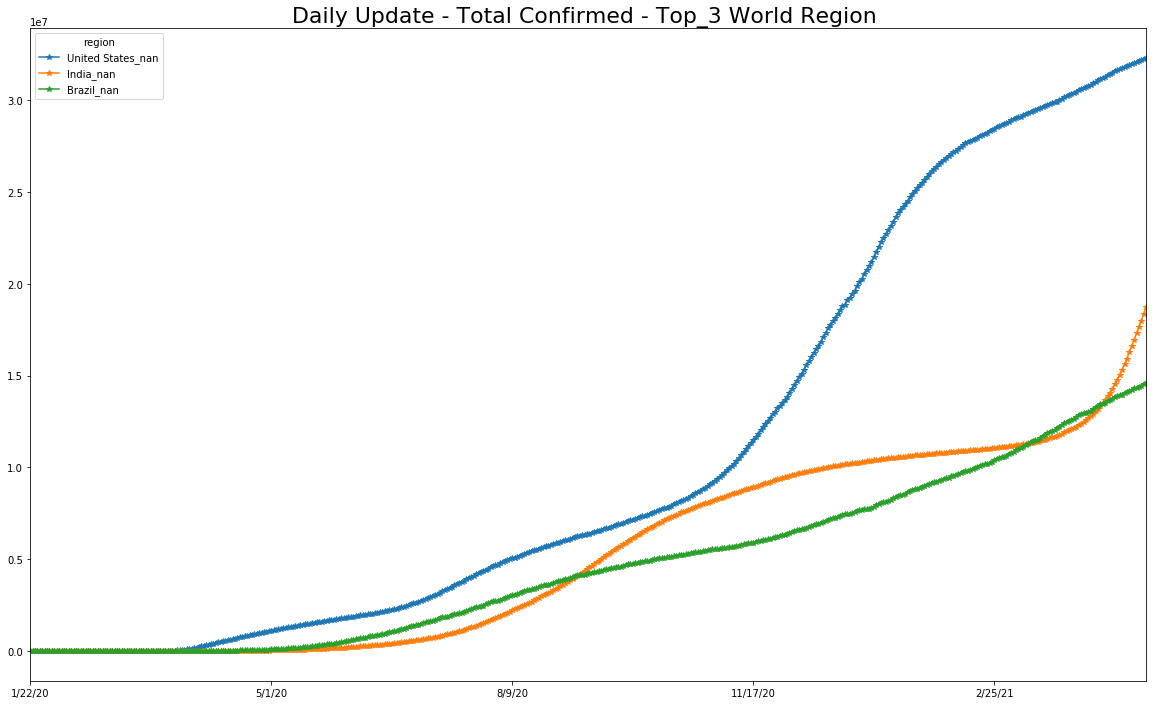

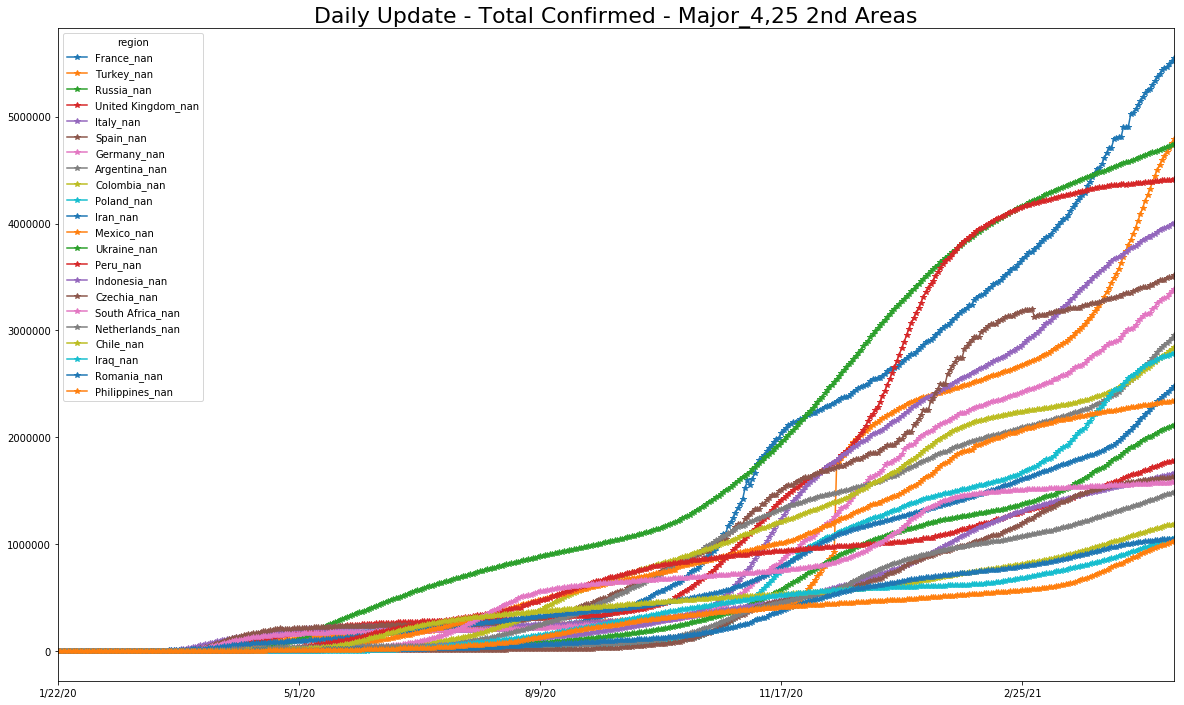

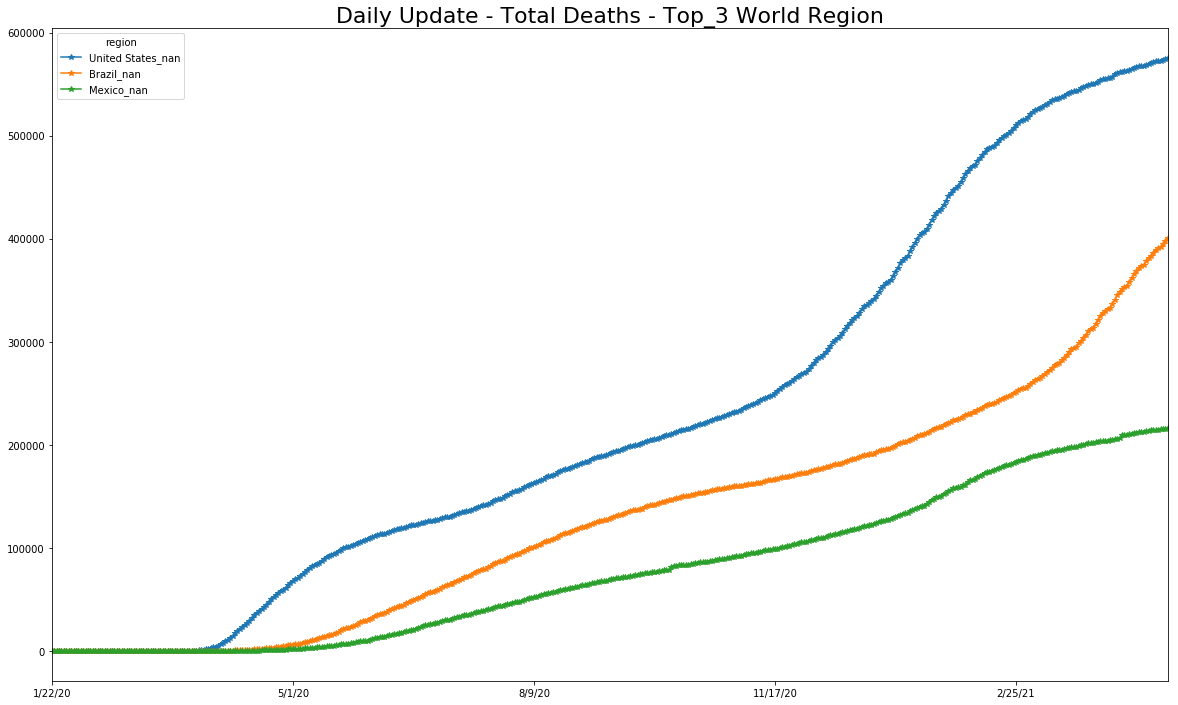

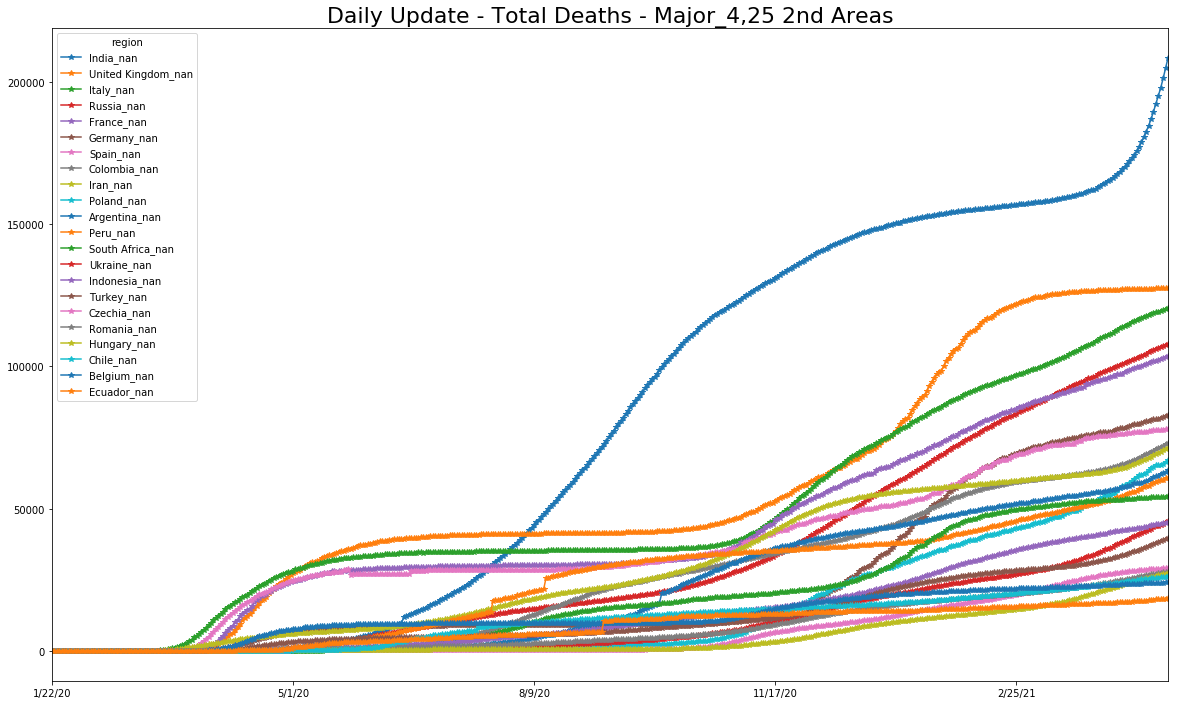

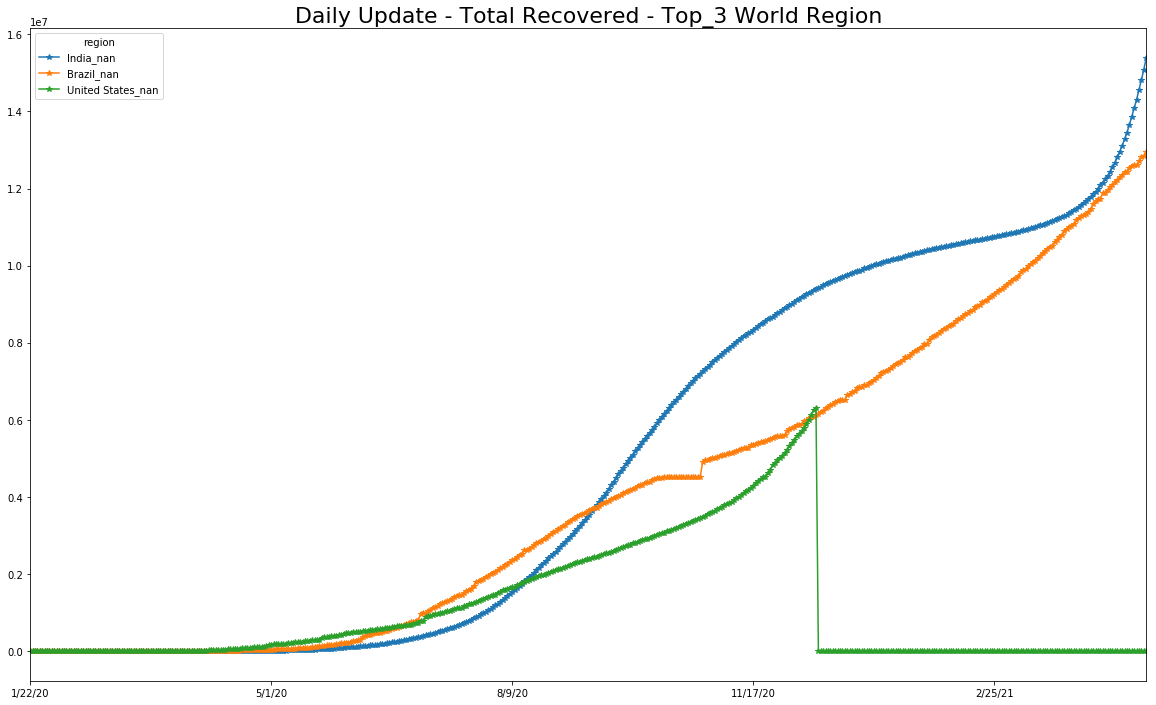

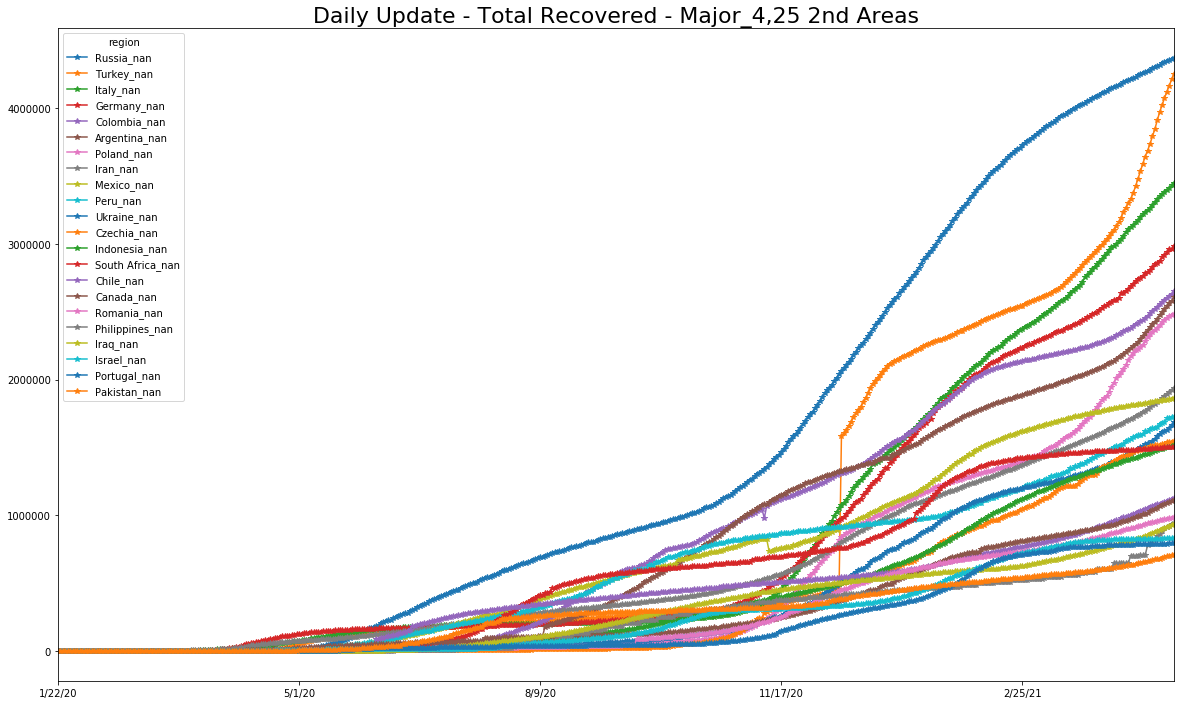

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/05/01


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
9/13/20            38716        11353        48254         1344        3388   
9/14/20            38772        11520        48496         1438        3439   
9/15/20            38815        11672        48734         1438        3569   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
9/13/20                       95         555537        45862   
9/14/20                       95         565446        45969   
9/15/20                       95         577338        46119   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
9/13/20                                     113                       4170   
9/14/20                                     113                       4177   
9/15/20                                     113                       4185   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
9/13/20  ...            6522914         1808           47287            0   
9/14/20  ...            6557342         1812           47836            0   
9/15/20  ...            6596849         1827           48429            0   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
9/13/20          60540         1063                   30574       2011   
9/14/20          61569         1063                   31362       2013   
9/15/20          62655         1063                   32250       2016   

region   Zambia_nan  Zimbabwe_nan  
9/13/20       13539          7526  
9/14/20       13720          7531  
9/15/20       13819          7576  

[3 rows x 275 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/26/21            59015       130606       121112        13083       25710   
4/27/21            59225       130736       121344        13121       25942   
4/28/21            59370       130859       121580        13148       26168   
4/29/21            59576       130977       121866        13198       26431   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/26/21                     1228        2879677       213469   
4/27/21                     1232        2905172       214064   
4/28/21                     1232        2928890       214872   
4/29/21                     1232        2954943       215528   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
4/26/21                                     123                       5440   
4/27/21                                     123                       5449   
4/28/21                                     123                       5464   
4/29/21                                     124                       5477   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
4/26/21  ...           32124869       187349           89355            4   
4/27/21  ...           32175725       190096           89630            4   
4/28/21  ...           32230850       193027           90008            4   
4/29/21  ...           32289049       195734           90406            4   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
4/26/21         192498         2852                  292052       6183   
4/27/21         193721         2857                  293466       6220   
4/28/21         194959         2865                  294550       6263   
4/29/21         196386         2910                  295601       6294   

region   Zambia_nan  Zimbabwe_nan  
4/26/21       91378         38102  
4/27/21       91418         38164  
4/28/21       91484         38191  
4/29/21       91533         38235  

[4 rows x 275 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-09-14  Afghanistan_nan      38772             0             0   
2     2020-09-15  Afghanistan_nan      38815            56             0   
3     2020-09-16  Afghanistan_nan      38855            43             0   
4     2020-09-17  Afghanistan_nan      38872            40           139   
5     2020-09-18  Afghanistan_nan      38897            17           100   
6     2020-09-19  Afghanistan_nan      38919            25            82   
7     2020-09-20  Afghanistan_nan      39044            22            64   
8     2020-09-21  Afghanistan_nan      39074           125           172   
9     2020-09-22  Afghanistan_nan      39096            30           177   
10    2020-09-23  Afghanistan_nan      39145            22           177   
11    2020-09-24  Afghanistan_nan      39170            49           101   
12    2020-09-25  Afghanistan_nan      39186            25            96   
13    2020-09-26  Afghanistan_nan      39192            16            90   
14    2020-09-27  Afghanistan_nan      39227             6            47   
15    2020-09-28  Afghanistan_nan      39239            35            57   
16    2020-09-29  Afghanistan_nan      39254            12            53   
17    2020-09-30  Afghanistan_nan      39268            15            62   
18    2020-10-01  Afghanistan_nan      39285            14            41   
19    2020-10-02  Afghanistan_nan      39290            17            46   
20    2020-10-03  Afghanistan_nan      39297             5            36   
21    2020-10-04  Afghanistan_nan      39341             7            29   
22    2020-10-05  Afghanistan_nan      39422            44            56   
23    2020-10-06  Afghanistan_nan      39486            81           132   
24    2020-10-07  Afghanistan_nan      39548            64           189   
25    2020-10-08  Afghanistan_nan      39616            62           207   
26    2020-10-09  Afghanistan_nan      39693            68           194   
27    2020-10-10  Afghanistan_nan      39703            77           207   
28    2020-10-11  Afghanistan_nan      39799            10           155   
29    2020-10-12  Afghanistan_nan      39870            96           183   
30    2020-10-13  Afghanistan_nan      39928            71           177   
...          ...              ...        ...           ...           ...   
64600 2021-04-01     Zimbabwe_nan      36896            43            60   
64601 2021-04-02     Zimbabwe_nan      36903            14            57   
64602 2021-04-03     Zimbabwe_nan      36911             7            64   
64603 2021-04-04     Zimbabwe_nan      36923             8            29   
64604 2021-04-05     Zimbabwe_nan      36934            12            27   
64605 2021-04-06     Zimbabwe_nan      36966            11            31   
64606 2021-04-07     Zimbabwe_nan      36984            32            55   
64607 2021-04-08     Zimbabwe_nan      37052            18            61   
64608 2021-04-09     Zimbabwe_nan      37147            68           118   
64609 2021-04-10     Zimbabwe_nan      37273            95           181   
64610 2021-04-11     Zimbabwe_nan      37288           126           289   
64611 2021-04-12     Zimbabwe_nan      37307            15           236   
64612 2021-04-13     Zimbabwe_nan      37330            19           160   
64613 2021-04-14     Zimbabwe_nan      37369            23            57   
64614 2021-04-15     Zimbabwe_nan      37422            39            81   
64615 2021-04-16     Zimbabwe_nan      37534            53           115   
64616 2021-04-17     Zimbabwe_nan      37699           112           204   
64617 2021-04-18     Zimbabwe_nan      37751           165           330   
64618 2021-04-19     Zimbabwe_nan      37859            52           329   
64619 2021-04-20     Zimbabwe_nan      37875           108           325   
64620 2021-04-21     Zimbabwe_nan      37980            16  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
64629 2021-04-30  Zimbabwe_nan          0            44           133   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
64629           217         100.115237         100.349089         100.570809   

       last_day  kalman_prediction  population  infected_rate  min  max  
64629     38235            38261.0    14862924       0.000026  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
64629 2021-04-30  Zimbabwe_nan          0            44           133   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
64629           217         100.115237         100.349089         100.570809   

       last_day  kalman_prediction  population  infected_rate  min  max  
64629     38235            38261.0    14862924       0.000026  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
63247  2021-04-28  Zimbabwe_nan      38191            62           100   
63248  2021-04-29  Zimbabwe_nan      38235            27           105   
63249  2021-04-30  Zimbabwe_nan          0            44           133   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
63247           289         100.162747         100.262742         100.763063   
63248           211         100.070774         100.275718         100.555582   
63249           217         100.115237         100.349089         100.570809   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
63247                38164  ...    14862924       0.000026  NaN  NaN   
63248                38191  ...    14862924       0.000026  NaN  NaN   
63249                38235  ...    14862924       0.000026  NaN  NaN   

       population_percentage : infected_rate confirmed  \
63247                                         0.002568   
63248                                         0.002570   
63249                                         0.002573   

       population_percentage : factor 9/10 infected_rate confirmed  \
63247                                           0.023110             
63248                                           0.023127             
63249                                           0.023153             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
63247                    34.0                           2.287571   
63248                    34.0                           2.287571   
63249                    26.0                           1.749319   

       delta : roling 7day AVG  \
63247                41.285714   
63248                30.142857   
63249                31.000000   

       delta : aprox 14-day case notification rate per 100k hab  
63247                                           3.888871         
63248                                           2.839280         
63249                                           2.920018         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
265  United States_nan  4.571630e+12  2.138137e+06  169490.768559


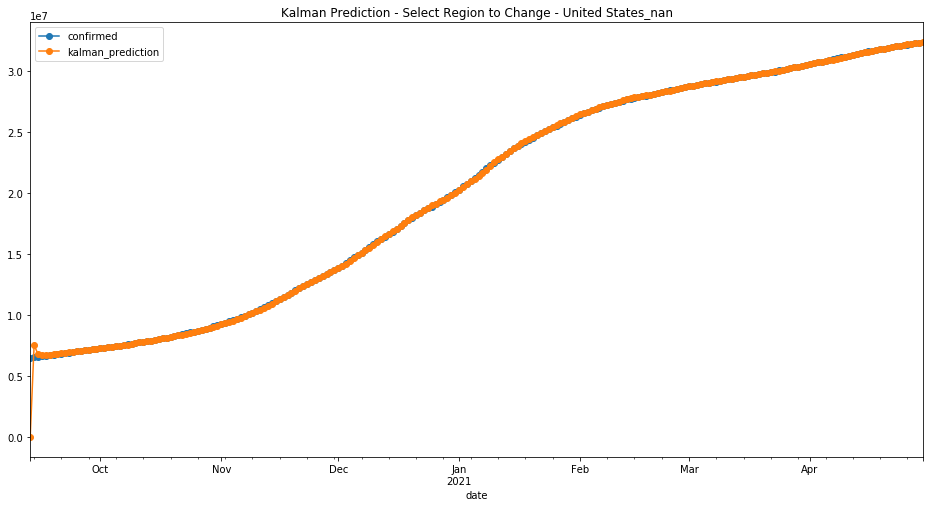

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse          mae
214  Russia_nan  9.867102e+10  314119.429153  23229.28821


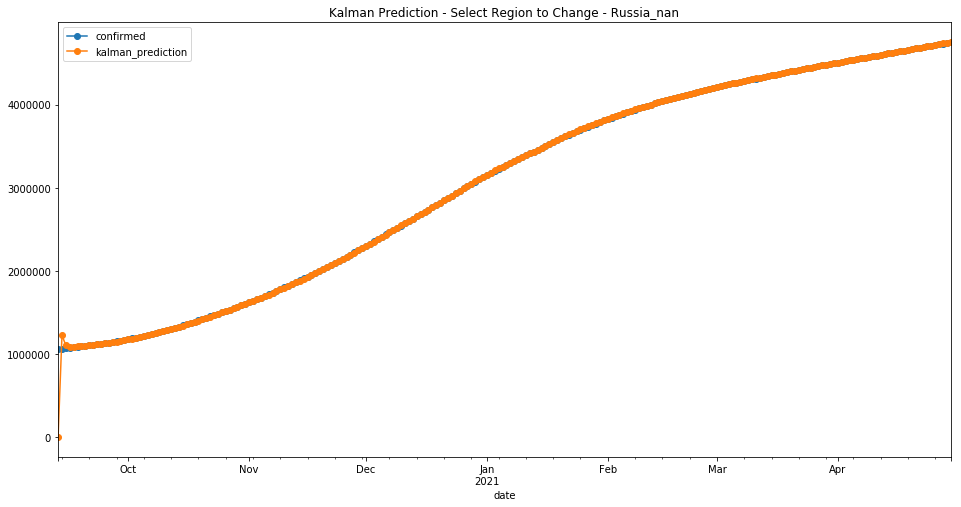

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  9.380439e+11  968526.669817  86521.056769


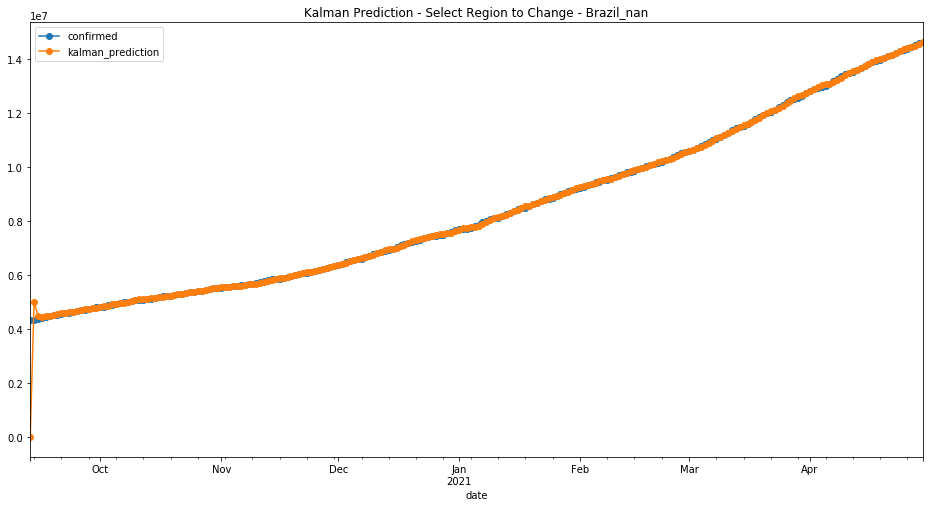

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse           mae
264  United Kingdom_nan  8.523701e+10  291953.78229  24227.235808


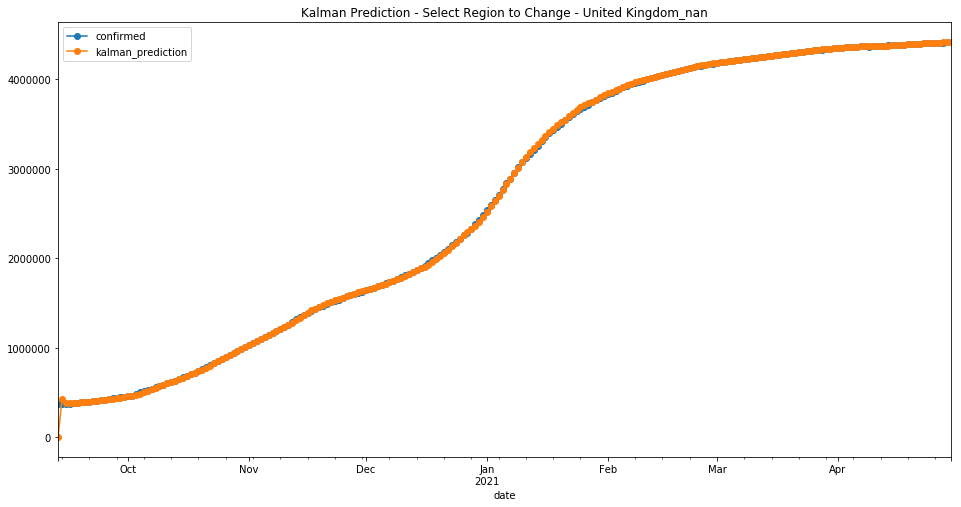

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1eizcts8
  JVM stdout: /tmp/tmp1eizcts8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1eizcts8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    2 years, 6 months and 4 days !!!
H2O cluster name:           H2O_from_python_unknownUser_a89pht
H2O cluster total nodes:    1
H2O cluster free memory:    3.543 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2021-04-24
last_train_date= 2021-04-30
first_bootstrap_date= 2021-04-22
boost_bootstrap_date= 2021-04-27
first_test_date= 2021-04-21
last_test_date= 2021-05-01
first_valid_date= 2021-04-29


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0    58377.0      58312 2021-04-22  Afghanistan_nan
1    58495.0      58542 2021-04-23  Afghanistan_nan
2    58721.0      58730 2021-04-24  Afghanistan_nan
3    58920.0      58843 2021-04-25  Afghanistan_nan
4    59068.0      59015 2021-04-26  Afghanistan_nan
5    59242.0      59225 2021-04-27  Afghanistan_nan
6    59447.0      59370 2021-04-28  Afghanistan_nan
7    59611.0      59576 2021-04-29  Afghanistan_nan
8    59814.0          0 2021-04-30  Afghanistan_nan
9   130032.0     130114 2021-04-22      Albania_nan
10  130158.0     130270 2021-04-23      Albania_nan
11  130308.0     130409 2021-04-24      Albania_nan
12  130444.0     130537 2021-04-25      Albania_nan
13  130573.0     130606 2021-04-26      Albania_nan
14  130639.0     130736 2021-04-27      Albania_nan
15  130769.0     130859 2021-04-28      Albania_nan
16  130881.0     130977 2021-04-29      Albania_nan
17  130998.0          0 2021-04-30      Albania_nan
18  120406.0     120363 2021-04-22      Algeria_nan
19  120599.0     120562 2021-04-23      Algeria_nan
20  120802.0     120736 2021-04-24      Algeria_nan
21  120980.0     120922 2021-04-25      Algeria_nan
22  121170.0     121112 2021-04-26      Algeria_nan
23  121359.0     121344 2021-04-27      Algeria_nan
24  121595.0     121580 2021-04-28      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  172029.0     172576 2021-04-26     Bahrain_nan
176  173250.0     173548 2021-04-27     Bahrain_nan
177  174211.0     174659 2021-04-28     Bahrain_nan
178  175358.0     175752 2021-04-29     Bahrain_nan
179  176437.0          0 2021-04-30     Bahrain_nan
180  736405.0     736074 2021-04-22  Bangladesh_nan
181  740287.0     739703 2021-04-23  Bangladesh_nan
182  743844.0     742400 2021-04-24  Bangladesh_nan
183  746346.0     745322 2021-04-25  Bangladesh_nan
184  749198.0     748628 2021-04-26  Bangladesh_nan
185  752331.0     751659 2021-04-27  Bangladesh_nan
186  755152.0     754614 2021-04-28  Bangladesh_nan
187  757993.0     756955 2021-04-29  Bangladesh_nan
188  760136.0          0 2021-04-30  Bangladesh_nan
189    3862.0       3806 2021-04-22    Barbados_nan
190    3849.0       3820 2021-04-23    Barbados_nan
191    3839.0       3820 2021-04-24    Barbados_nan
192    3908.0       3824 2021-04-25    Barbados_nan
193    3890.0       3825 2021-04-26    Barbados_nan
194    3899.0       3828 2021-04-27    Barbados_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date      region
220  12604.0      12624 2021-04-26  Belize_nan
221  12595.0      12631 2021-04-27  Belize_nan
222  12626.0      12639 2021-04-28  Belize_nan
223  12637.0      12646 2021-04-29  Belize_nan
224  12642.0          0 2021-04-30  Belize_nan
225   7871.0       7720 2021-04-22   Benin_nan
226   7886.0       7720 2021-04-23   Benin_nan
227   7860.0       7720 2021-04-24   Benin_nan
228   7858.0       7720 2021-04-25   Benin_nan
229   7853.0       7720 2021-04-26   Benin_nan
230   7847.0       7720 2021-04-27   Benin_nan
231   7844.0       7821 2021-04-28   Benin_nan
232   7724.0       7821 2021-04-29   Benin_nan
233   7964.0          0 2021-04-30   Benin_nan
234    776.0        992 2021-04-22  Bhutan_nan
235   1074.0       1008 2021-04-23  Bhutan_nan
236    917.0       1018 2021-04-24  Bhutan_nan
237   1030.0       1022 2021-04-25  Bhutan_nan
238   1150.0       1026 2021-04-26  Bhutan_nan
239   1133.0       1053 2021-04-27  Bhutan_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  6269122426.578064
# MSE on the validation data =  22231513029237.11
# R^2 on the training data =  0.9996536943536277
# R^2 on the validation data =  -0.03179199532922716


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1619844355572_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 6269122426.578064
RMSE: 79177.78998291165
MAE: 7541.372969767621
RMSLE: 0.26025922201716734
Mean Residual Deviance: 6269122426.578064

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 22231513029237.11
RMSE: 4715030.543828651
MAE: 1537155.1913454565
RMSLE: 9.396477756395186
Mean Residual Deviance: 22231513029237.11
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2021-05-01 04:46:04  0.074 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2021-05-01 04:46:04  0.482 sec   1.0                95417.4155500651    15843.406591397814  9104483190.253803    4913060.212046297   1582439.2939189188  24138160647192.41
     2021-05-01 04:46:05  0.634 sec   2.0                76034.19251556887   17132.748417755567  5781198431.494588    4466793.179208977   1525400.9054054054  19952241305827.844
     2021-05-01 04:46:05  0.753 sec   3.0                105476.10755544405  18780.70251274886   11125209265.0476     4565399.3545475565  1537133.0845562362  20842871266503.242
     2021-05-01 04:46:05  1.045 sec   4.0                177943.66677243257  20806.014886061723  31663948544.418526   4631728.873117393   1542454.072918866   21452912354069.316
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2021-05-01 04:46:20  16.250 sec  228.0              77076.1875744885    7815.681560334155   5940738691.017736    4716045.980474191   1537462.538811962   22241089689946.77
     2021-05-01 04:46:24  20.255 sec  305.0              77167.553441383     7703.860493899253   5954831304.128702    4720841.516219646   1538309.204222631   22286344621263.008
     2021-05-01 04:46:28  24.282 sec  383.0              77503.37233630408   7641.528764263896   6006772723.4997835   4722494.807569828   1537686.3532564961  22301957207523.99
     2021-05-01 04:46:32  28.363 sec  458.0              78381.30061005187   7550.495716602846   6143628285.323317    4728304.048347727   1539575.0818713913  22356859173621.51
     2021-05-01 04:46:35  30.679 sec  500.0              79177.78998291165   7541.372969767621   6269122426.578064    4715030.543828651   1537155.1913454565  22231513029237.11


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  2.47462e+19            1                    0.347879
last_day           2.00854e+19            0.811657             0.282359
region             9.83653e+18            0.397497             0.138281
7_day_change       5.60164e+18            0.226364             0.0787472
3_day_change       3.19978e+18            0.129304             0.0449821
1_day_change       2.75993e+18            0.11153              0.0387988
infected_rate      1.97749e+18            0.079911             0.0277994
min                1.45092e+18            0.058632             0.0203968
max                1.13622e+18            0.0459149            0.0159728
7_day_change_rate  1.29682e+17            0.00524047           0.00182305
3_day_change_rate  1.13108e+17            0.00457075           0.00159007
1_day_change_rate  9.75577e+16            0.00394233           0.00137146

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.474617e+19           1.000000    0.347879
1            last_day         2.008541e+19           0.811657    0.282359
2              region         9.836527e+18           0.397497    0.138281
3        7_day_change         5.601640e+18           0.226364    0.078747
4        3_day_change         3.199777e+18           0.129304    0.044982
5        1_day_change         2.759930e+18           0.111530    0.038799
6       infected_rate         1.977492e+18           0.079911    0.027799
7                 min         1.450918e+18           0.058632    0.020397
8                 max         1.136217e+18           0.045915    0.015973
9   7_day_change_rate         1.296815e+17           0.005240    0.001823
10  3_day_change_rate         1.131085e+17           0.004571    0.001590
11  1_day_change_rate         9.755769e+16           0.003942    0.001371

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


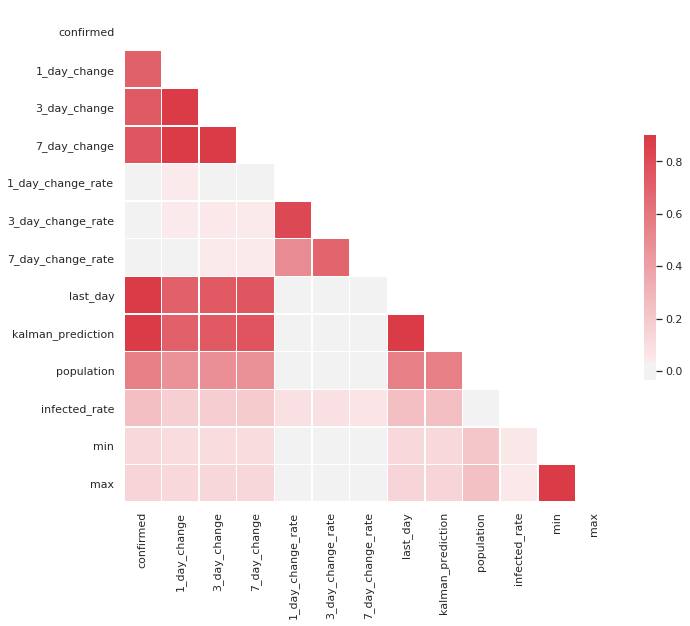

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.707690
3_day_change         0.740822
7_day_change         0.761716
1_day_change_rate    0.024196
3_day_change_rate    0.022357
7_day_change_rate    0.014735
last_day             0.993942
kalman_prediction    0.994221
population           0.559666
infected_rate        0.248997
min                  0.119965
max                  0.141089
Name: confirmed, dtype: float64


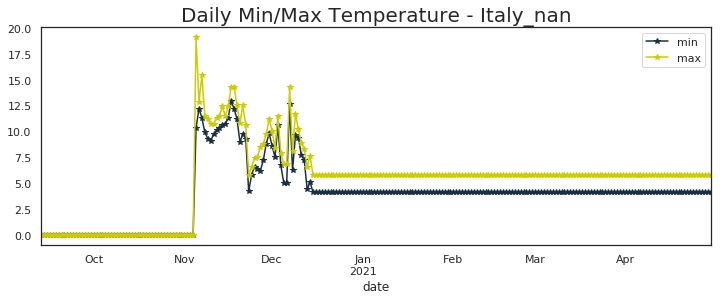

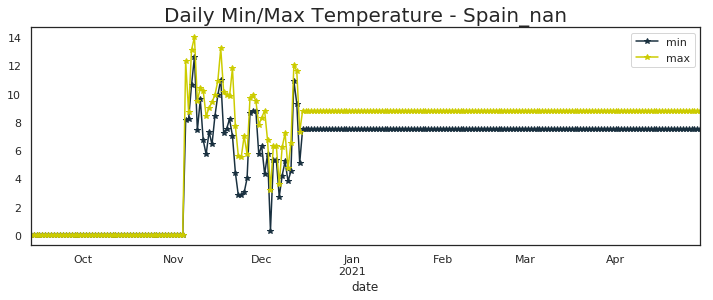

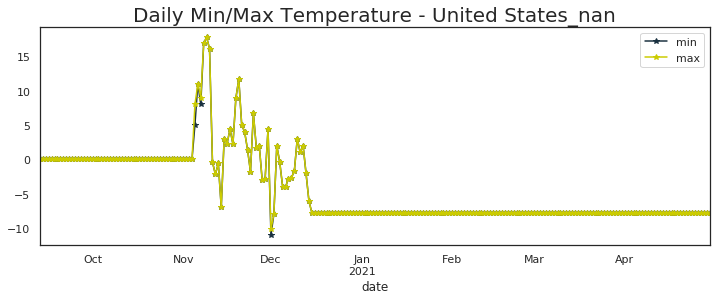

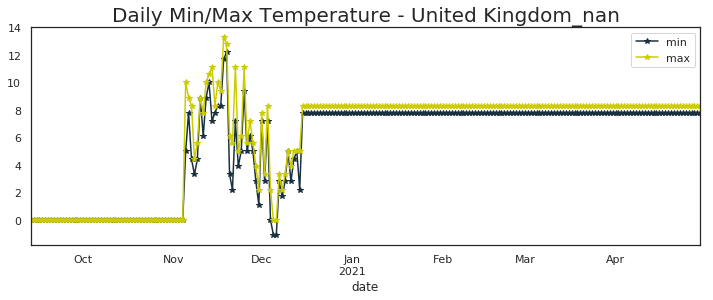

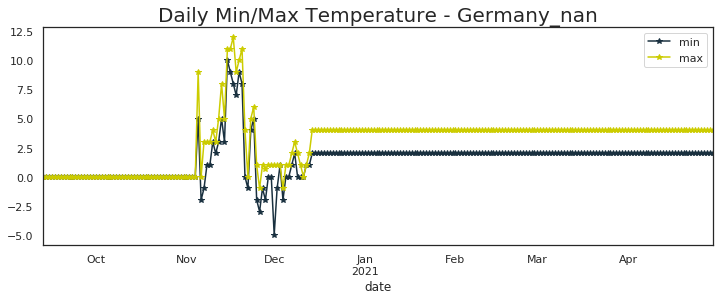

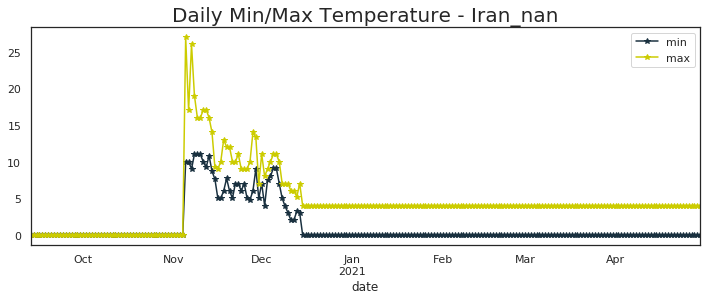

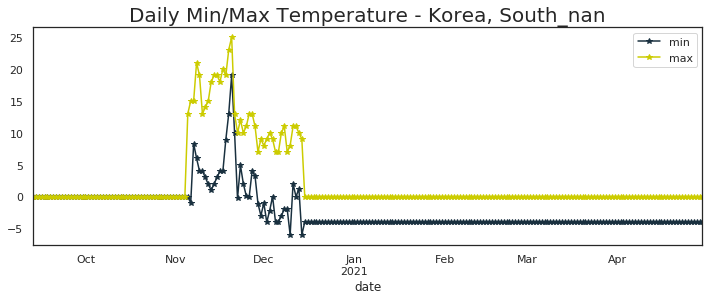

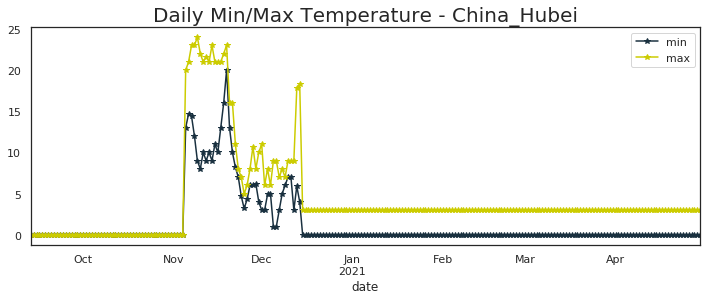

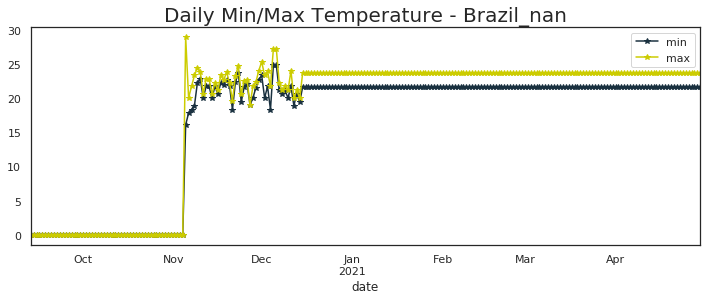

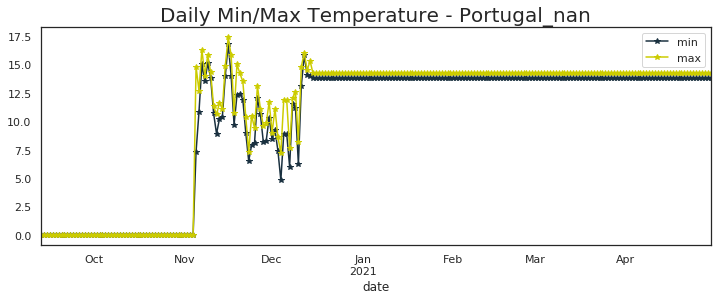

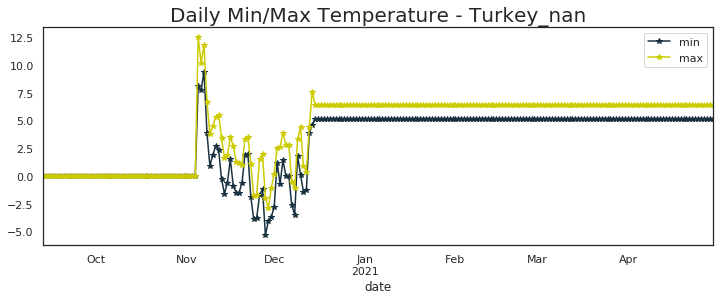

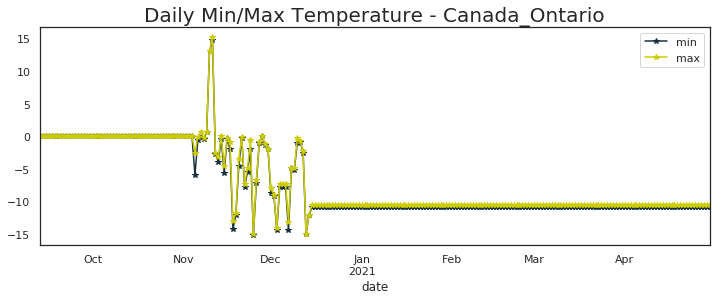

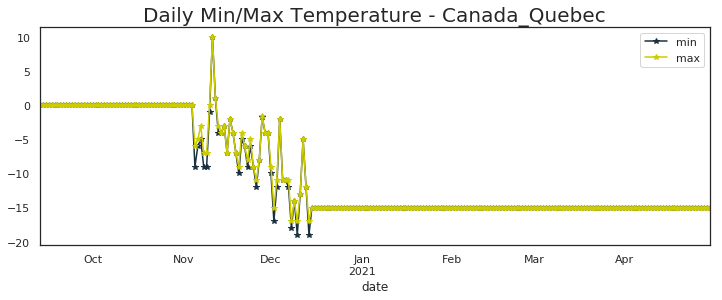

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   22.0  31.0
Brazil_nan                  24.8  28.9
France_nan                  12.1  13.3
Turkey_nan                   9.4  12.5
Russia_nan                   0.0   4.0
United Kingdom_nan          12.2  13.3
Italy_nan                   12.9  19.1
Spain_nan                   12.6  14.0
Germany_nan                 10.0  12.0
Argentina_nan                0.0   0.0
Colombia_nan                 0.0   0.0
Poland_nan                   8.9  10.6
Iran_nan                    11.0  27.0
Mexico_nan                  15.1  15.1
Ukraine_nan                  0.0   0.0
Peru_nan                    24.6  29.9
Indonesia_nan                0.0   0.0
Czechia_nan                  0.0   0.0
South Africa_nan             0.0   0.0
Netherlands_nan             14.4  16.1
Chile_nan                   18.0  22.0
Iraq_nan                    

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

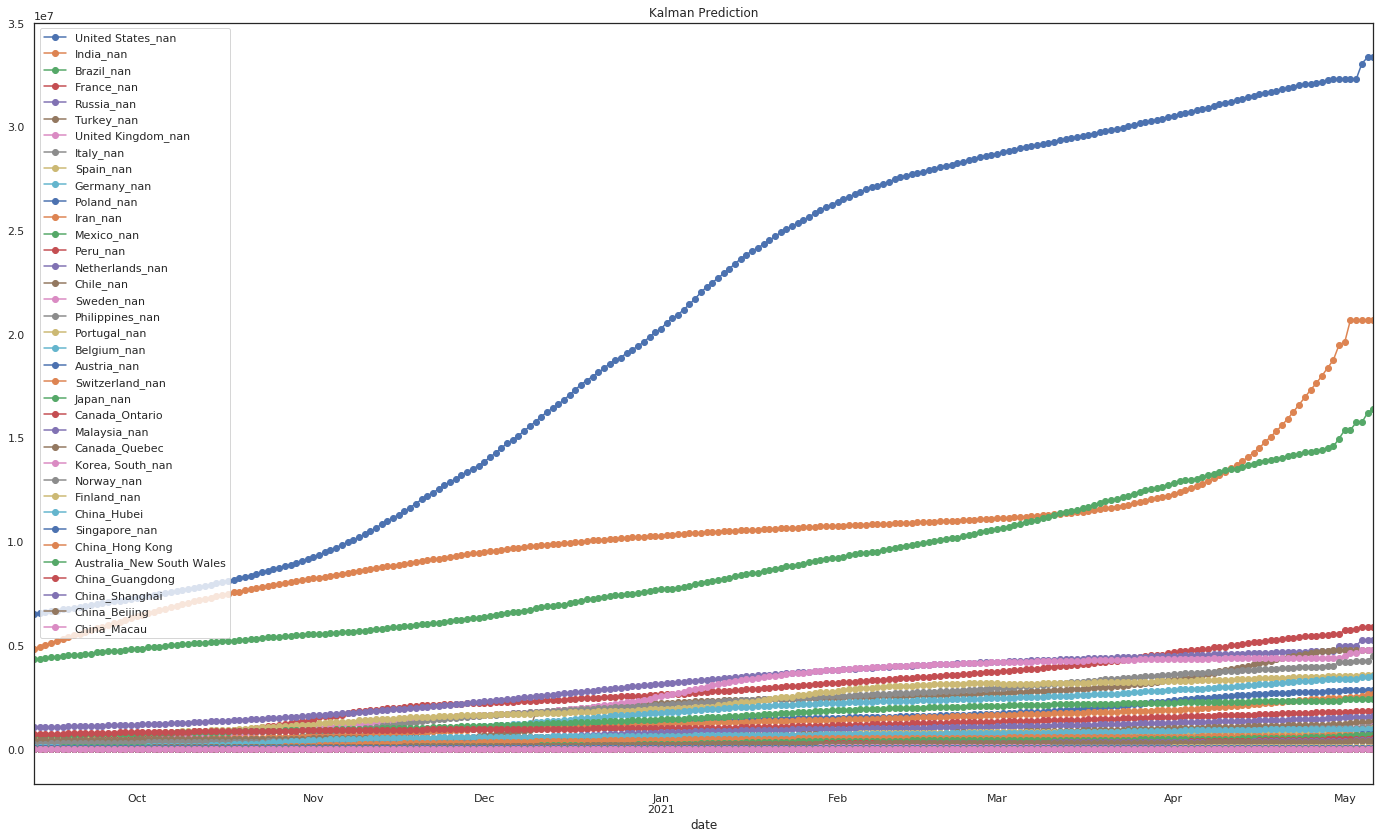

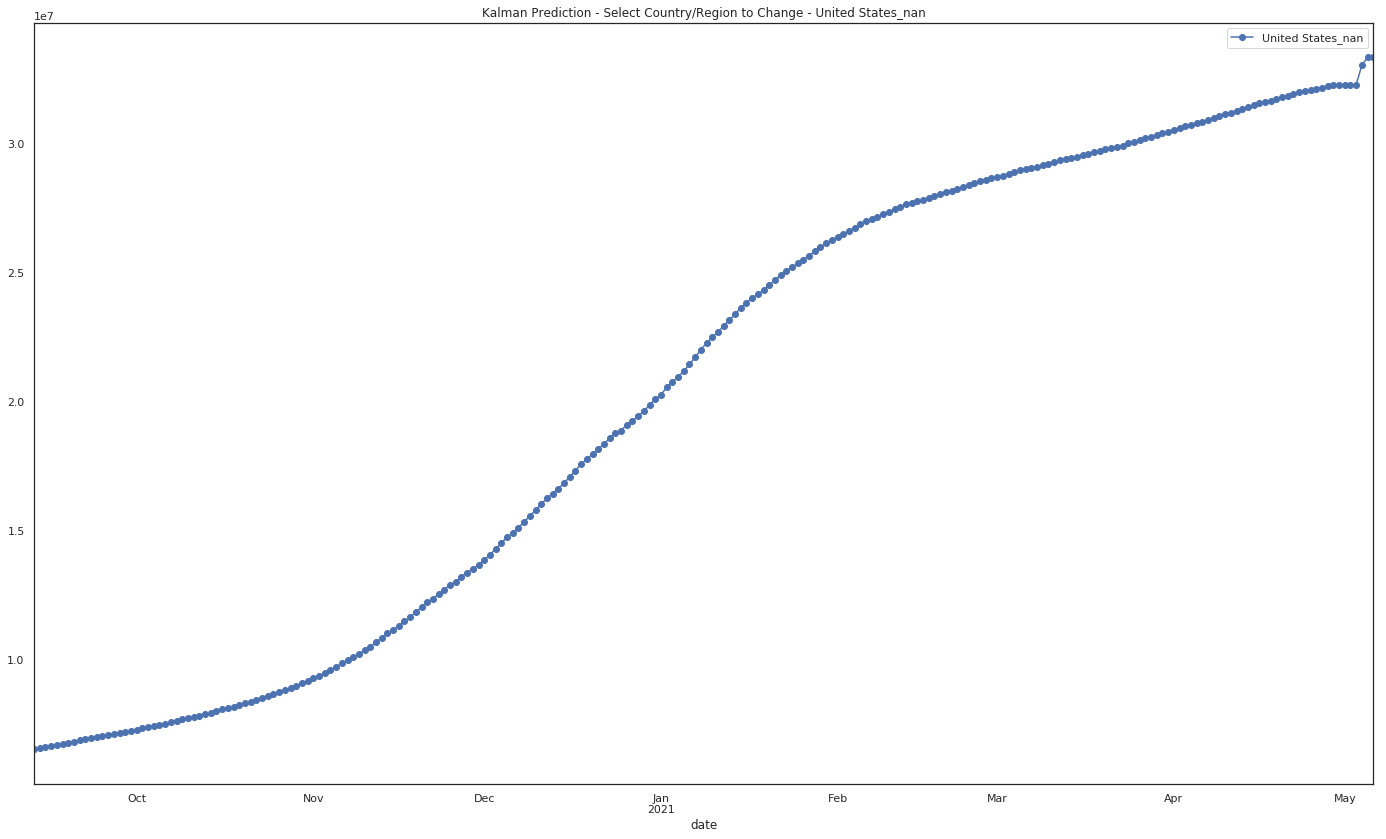

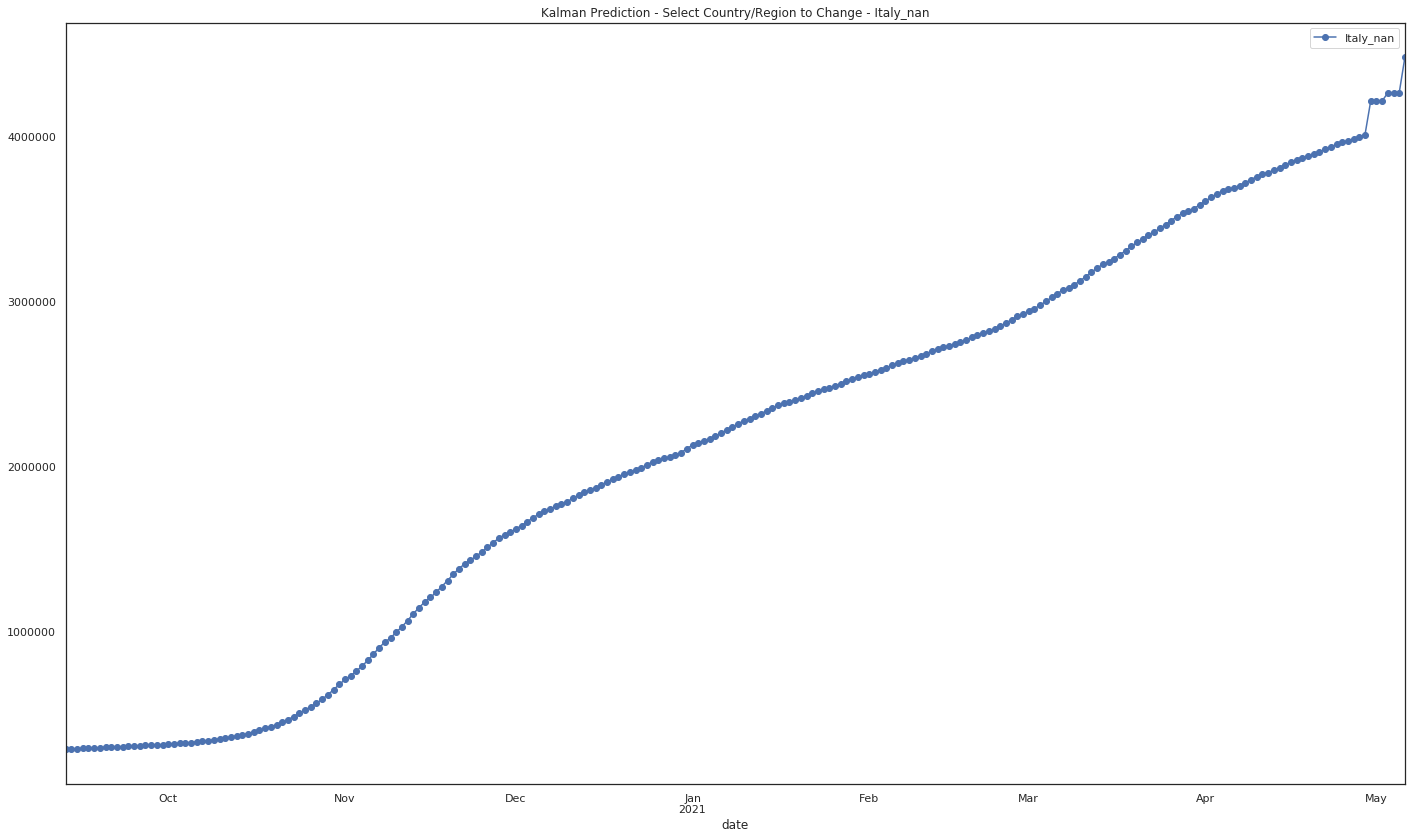

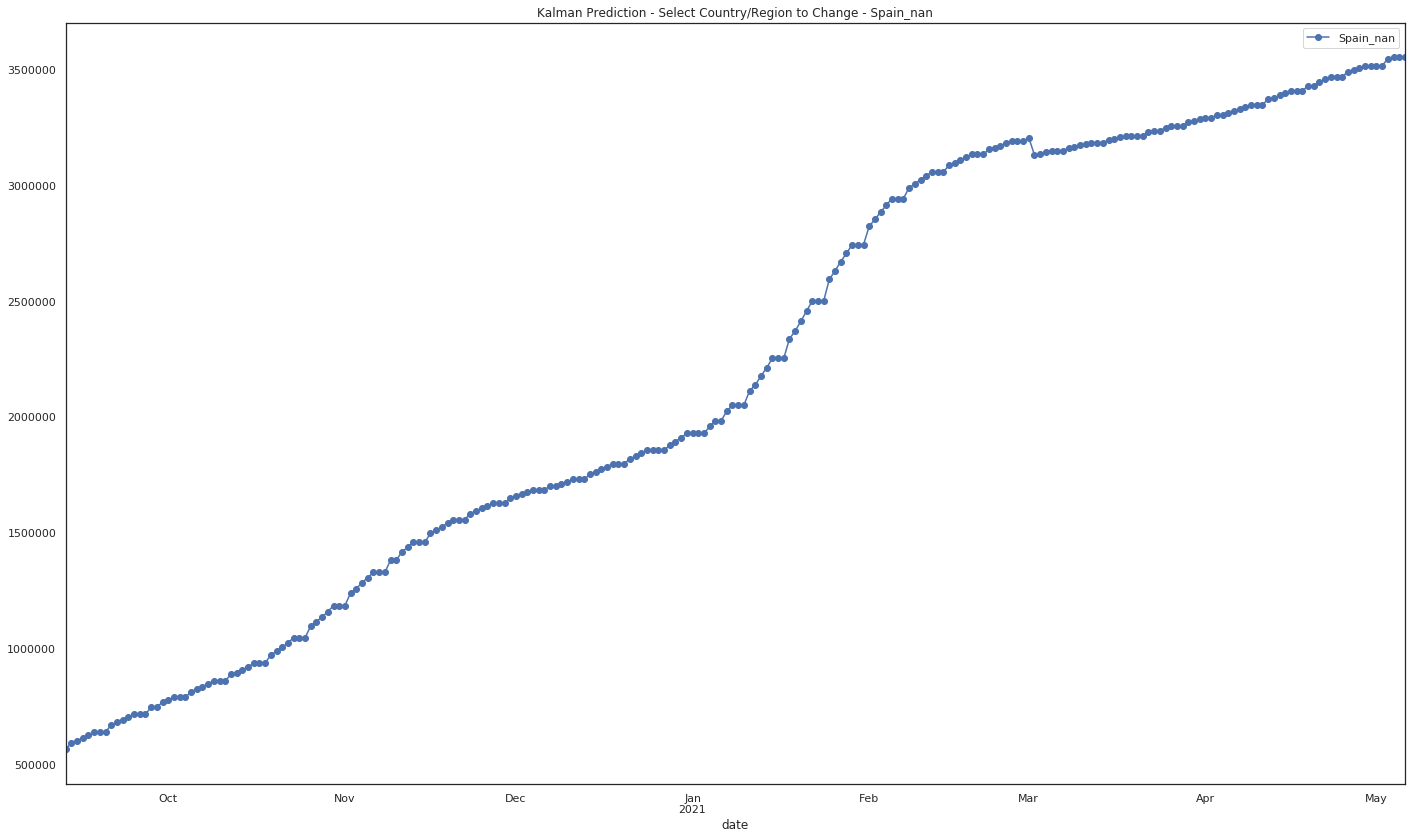

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


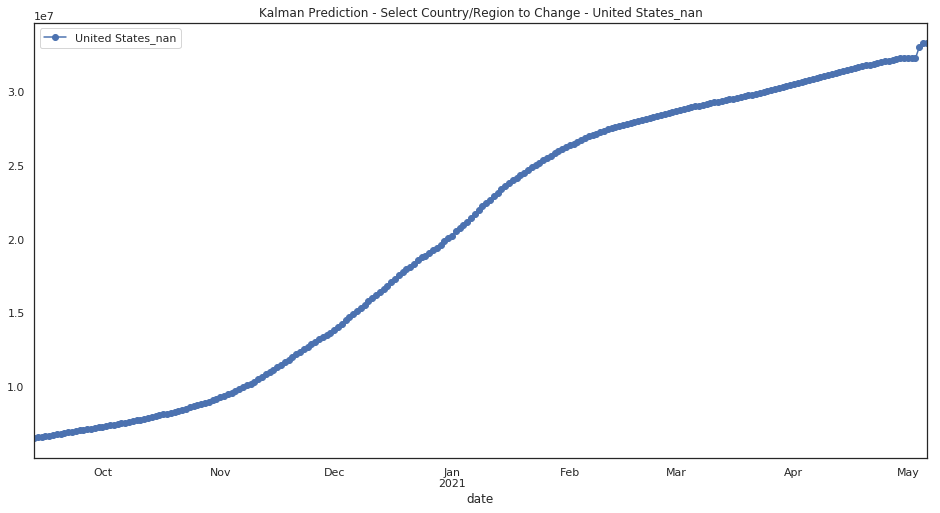

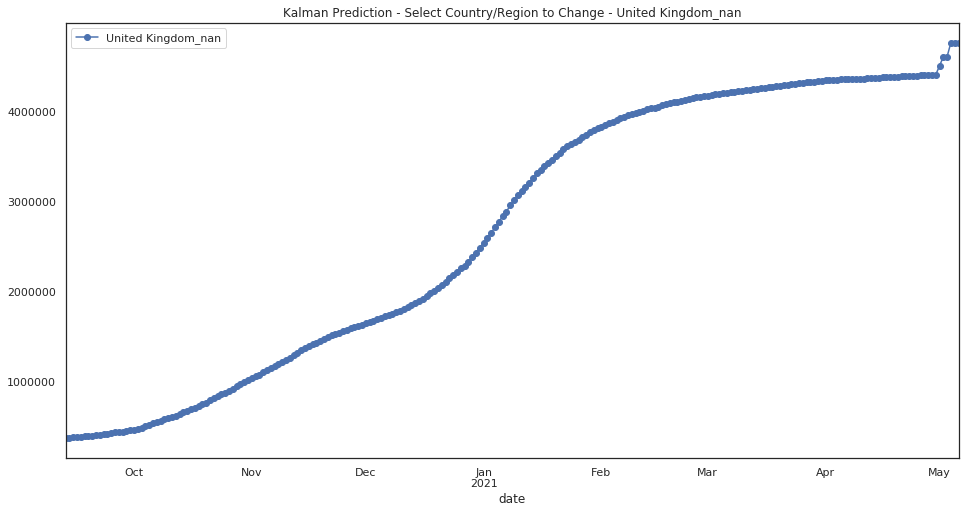

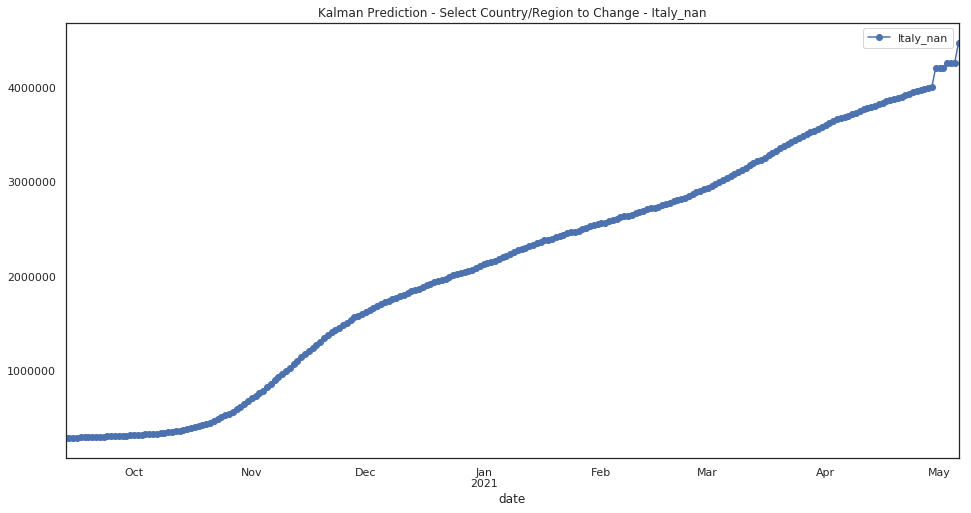

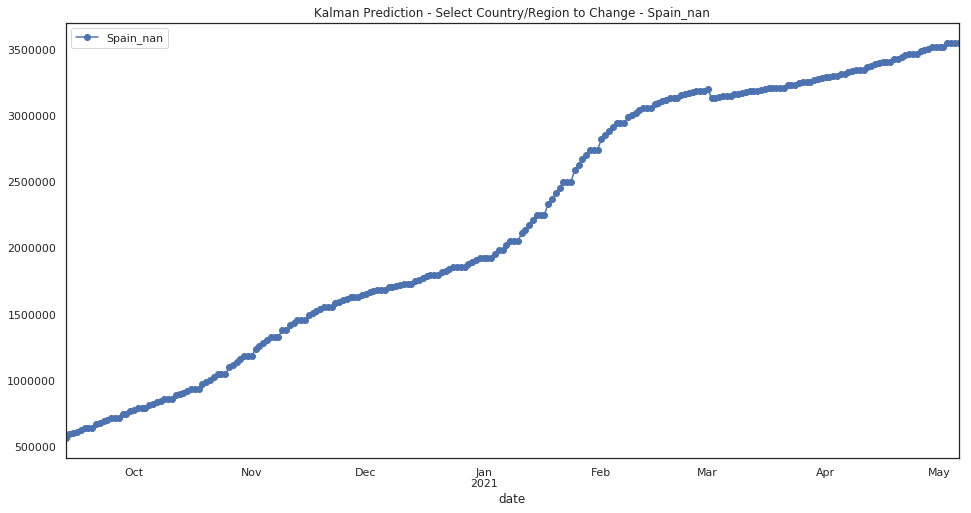

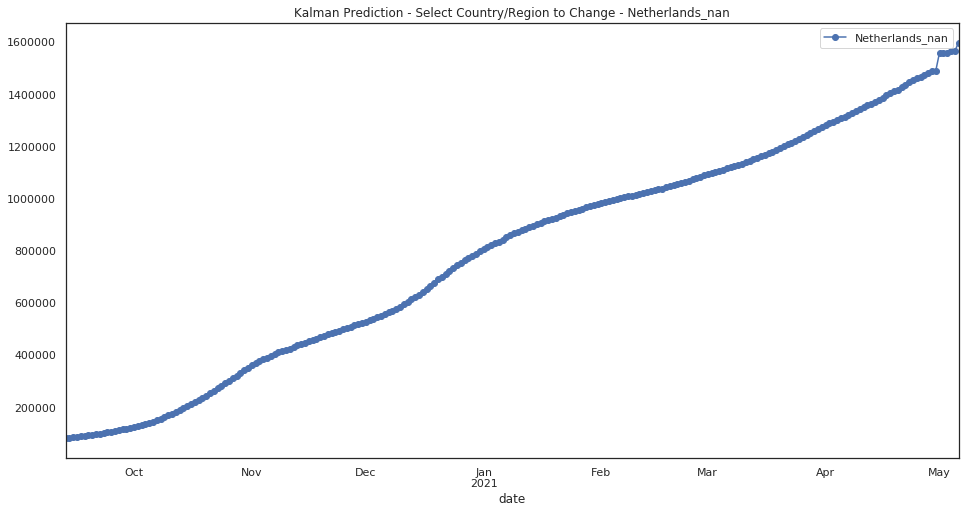

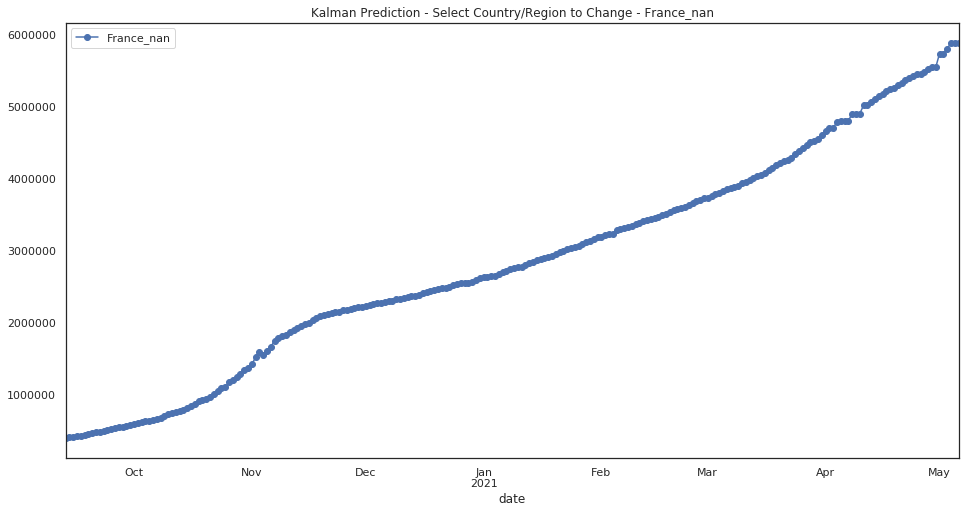

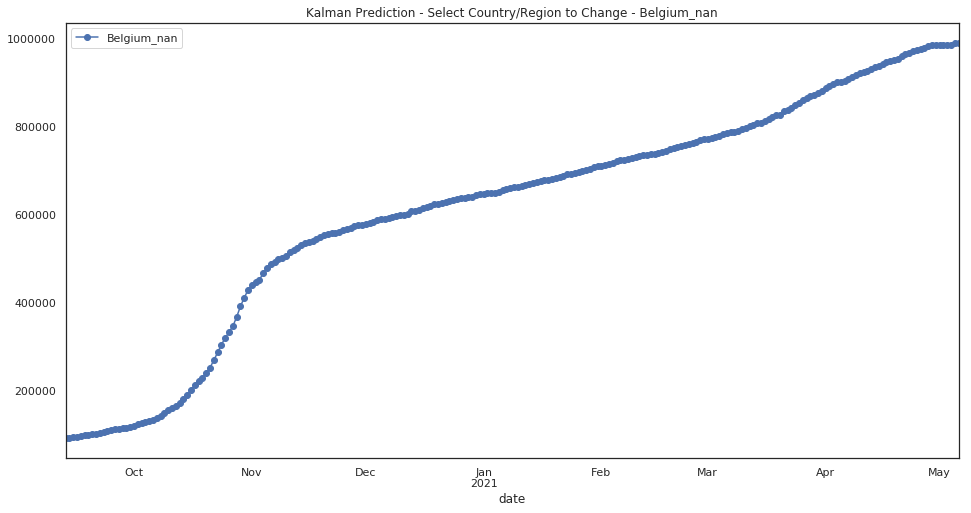

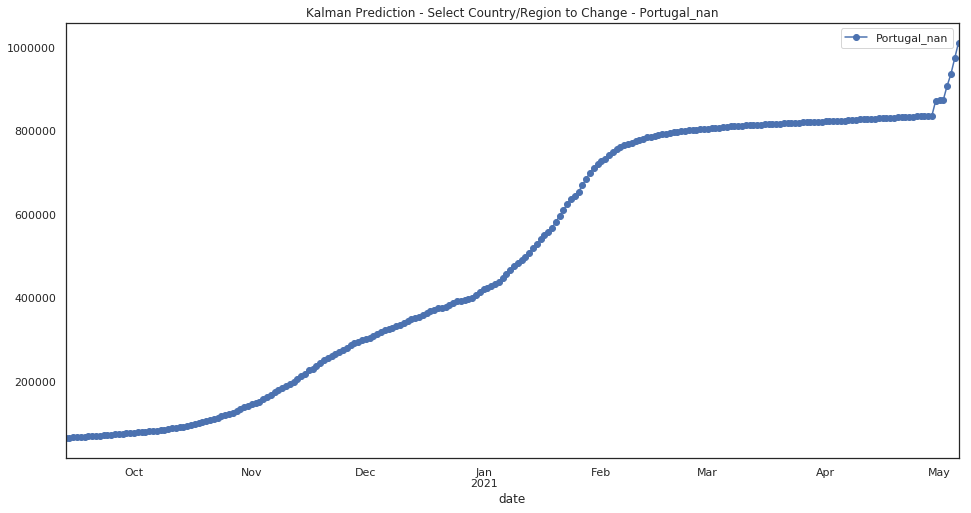

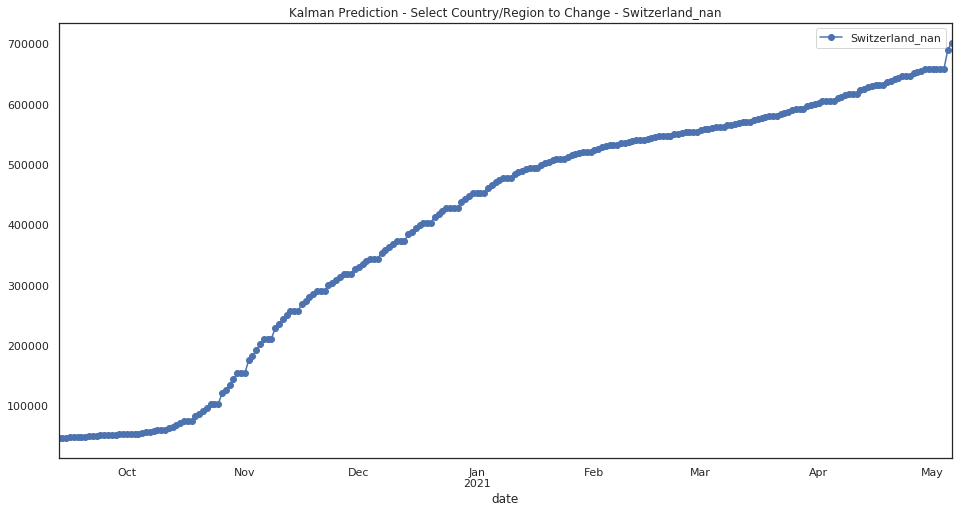

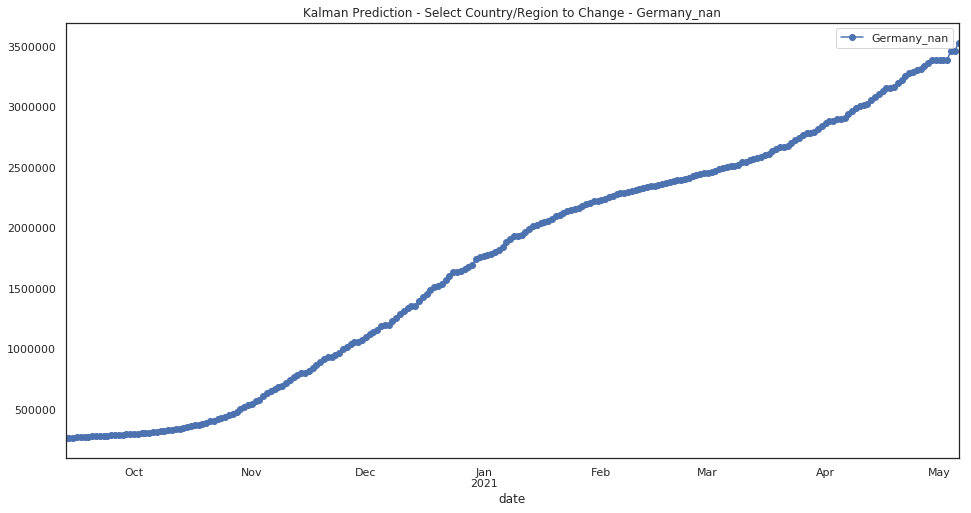

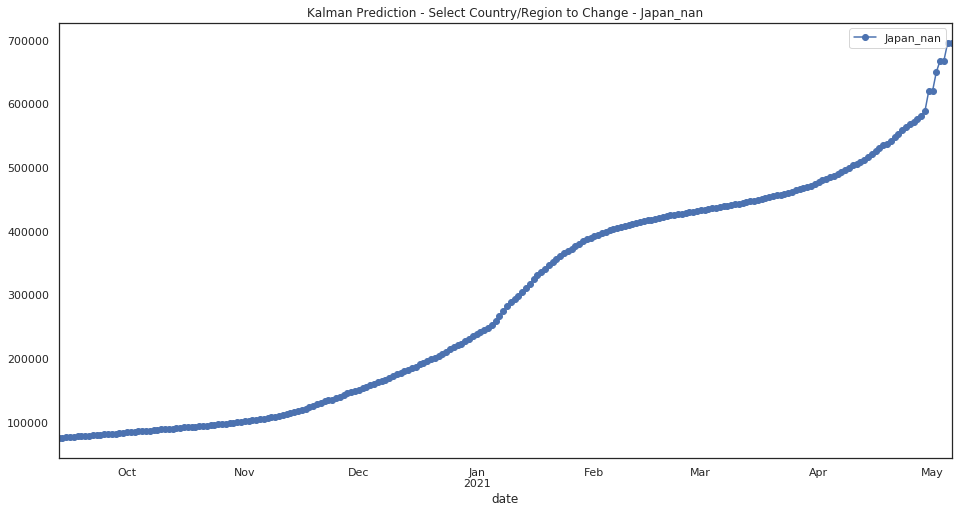

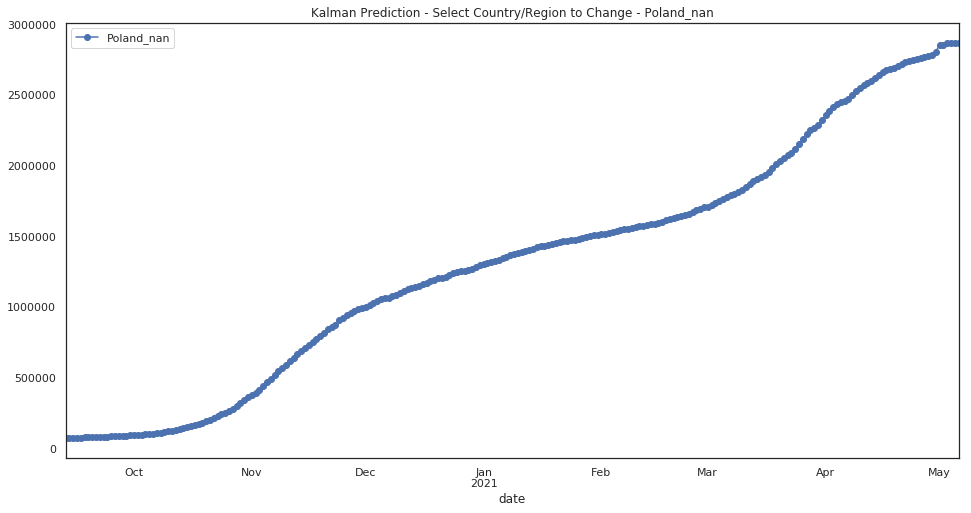

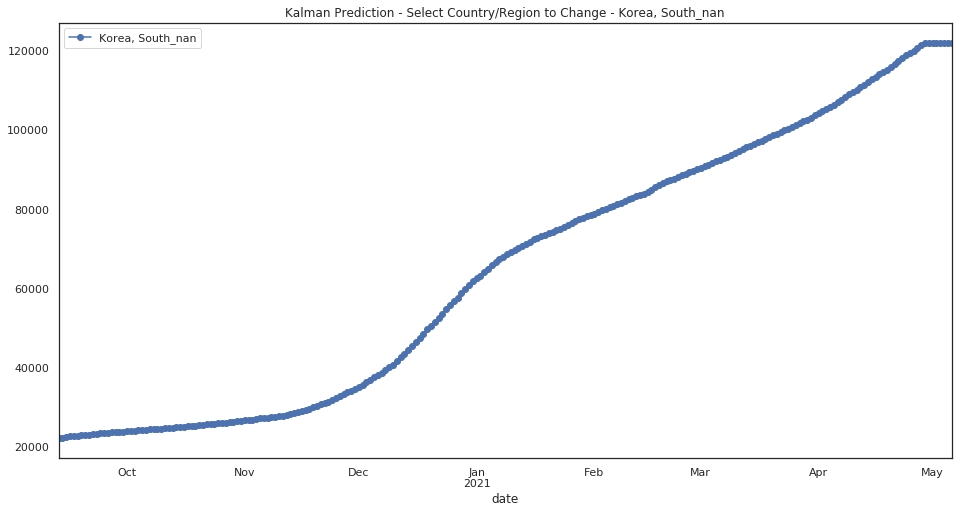

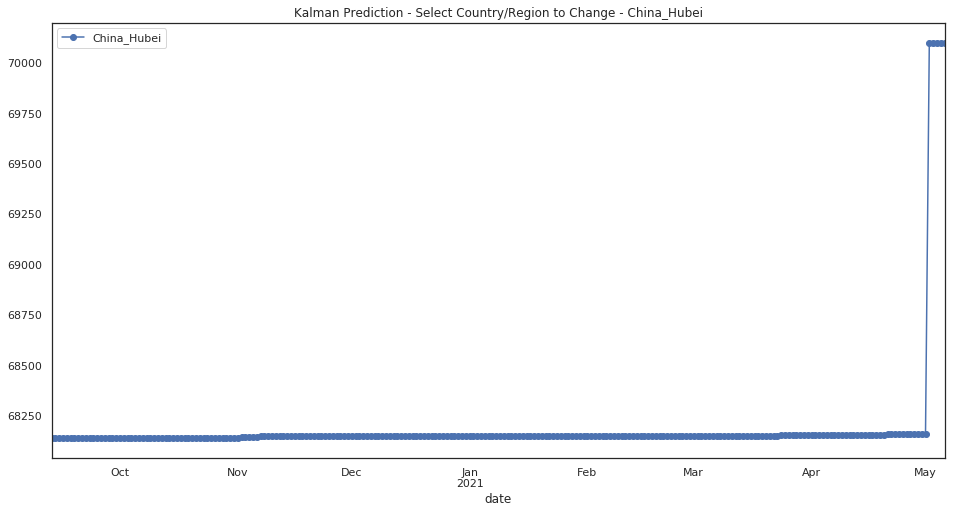

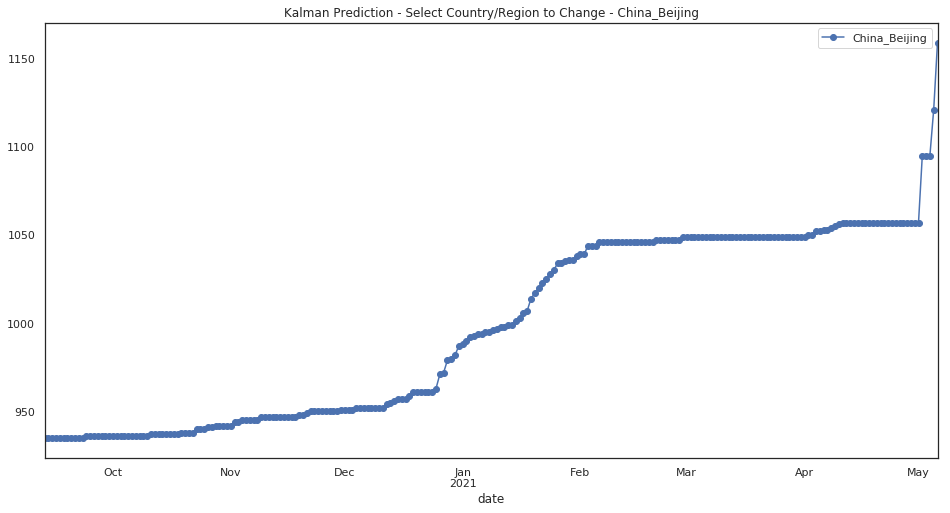

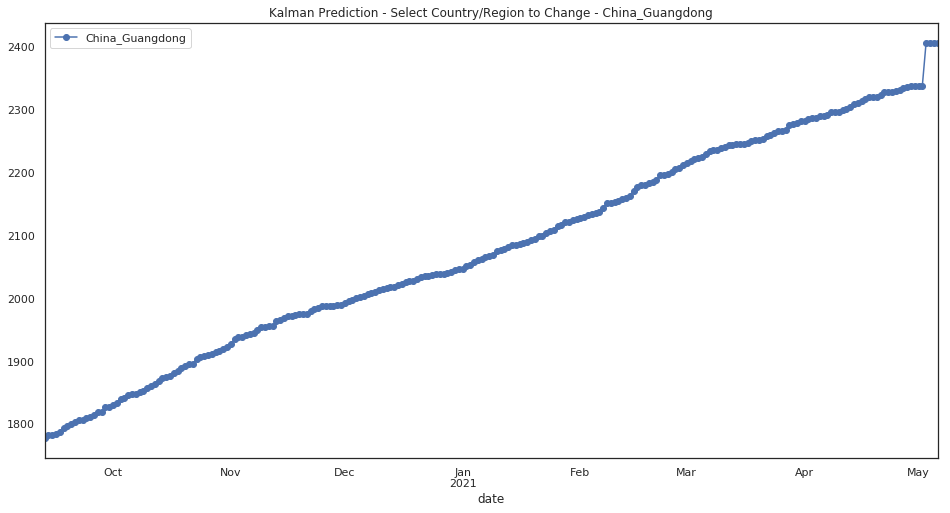

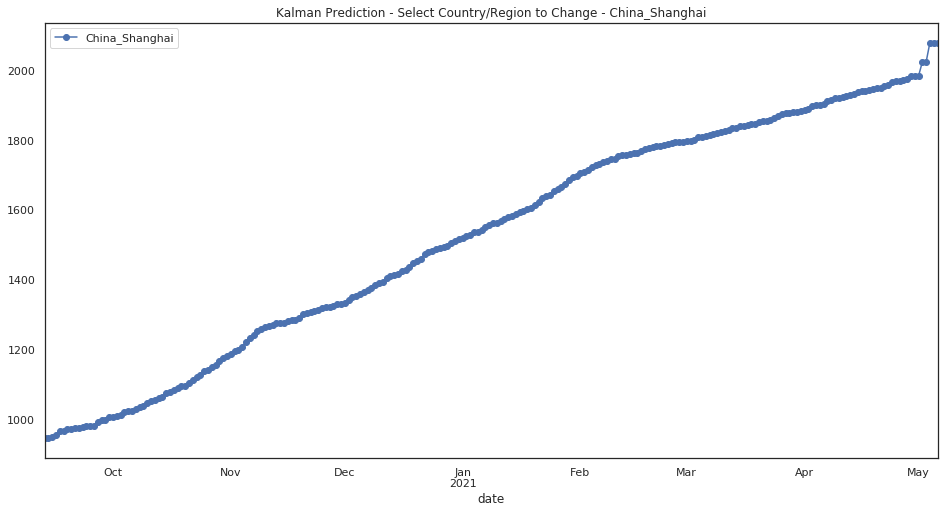

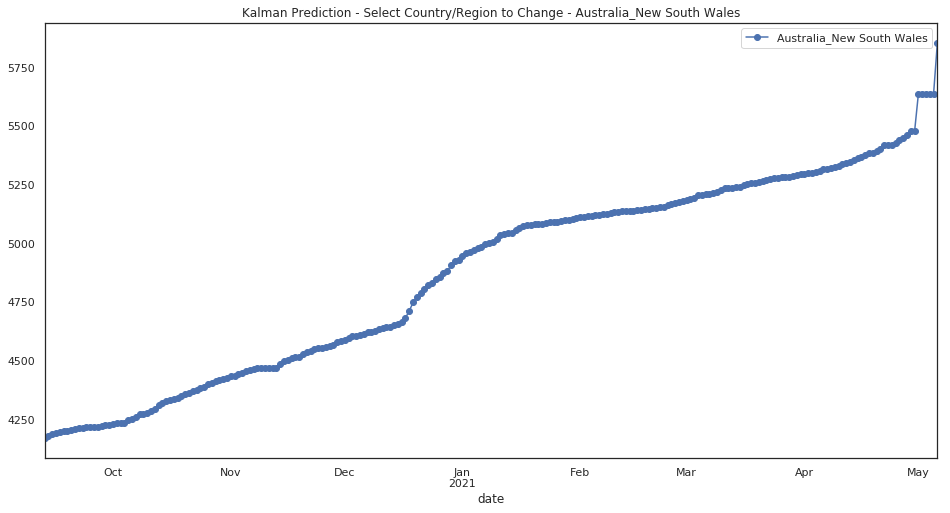

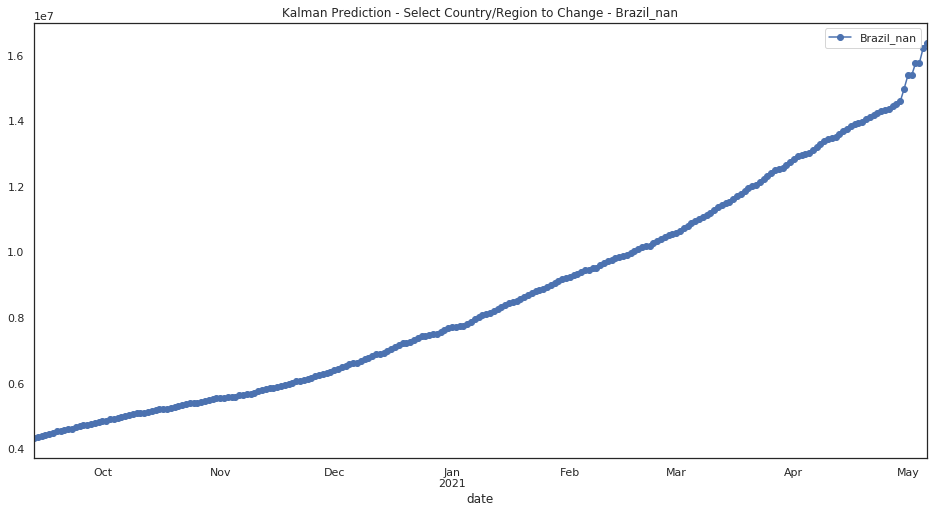

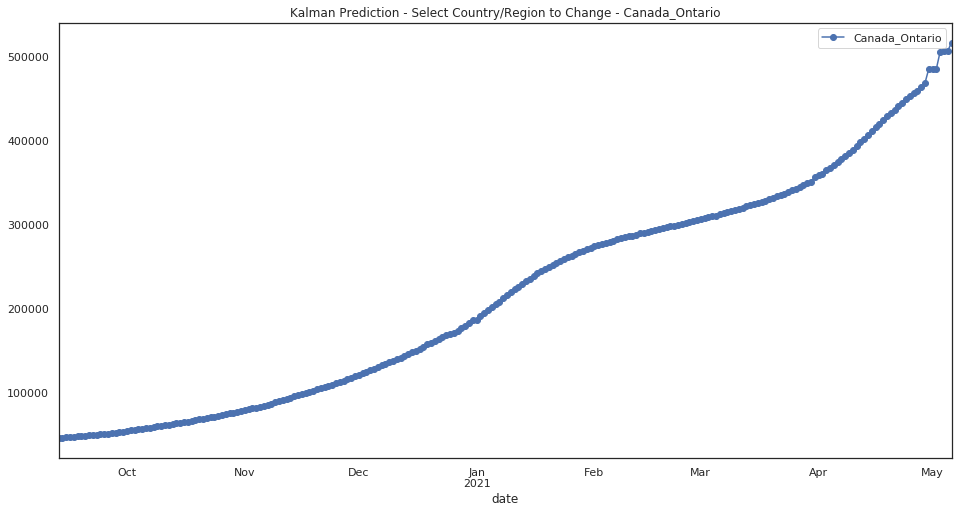

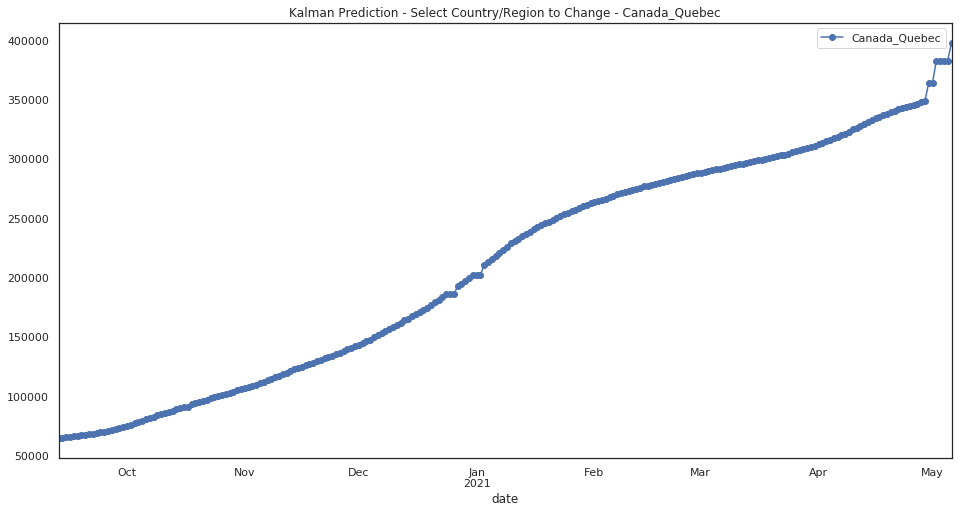

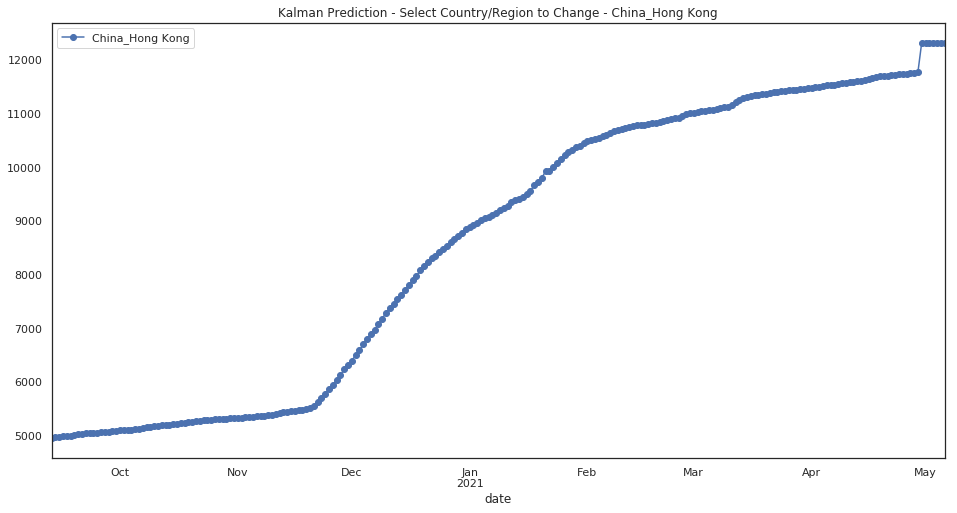

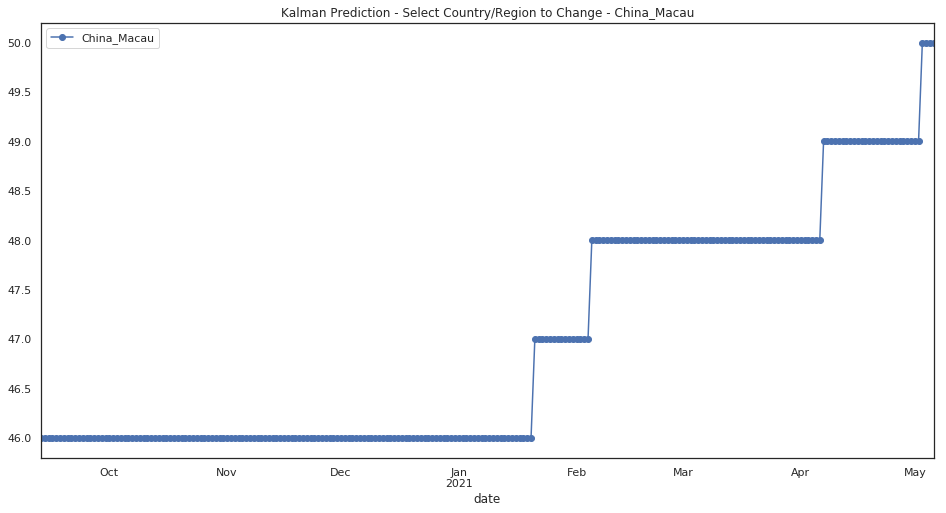

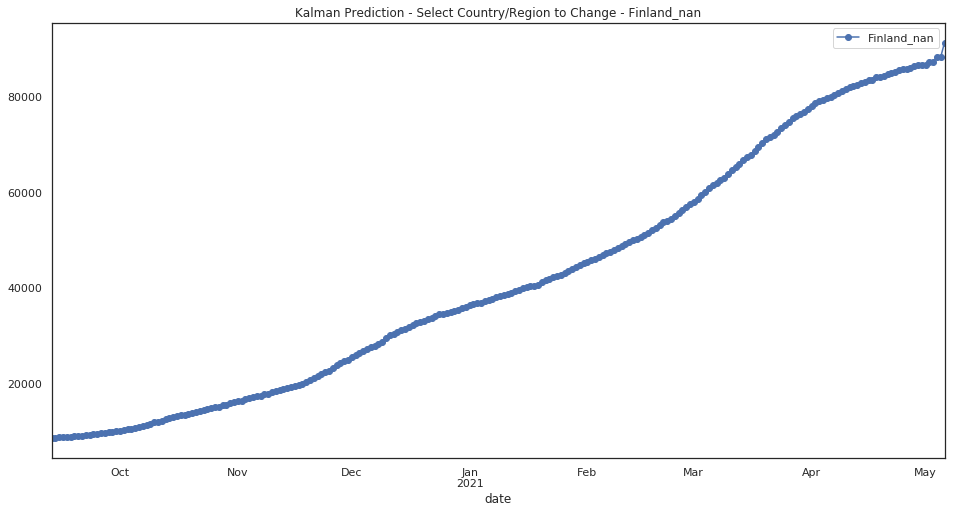

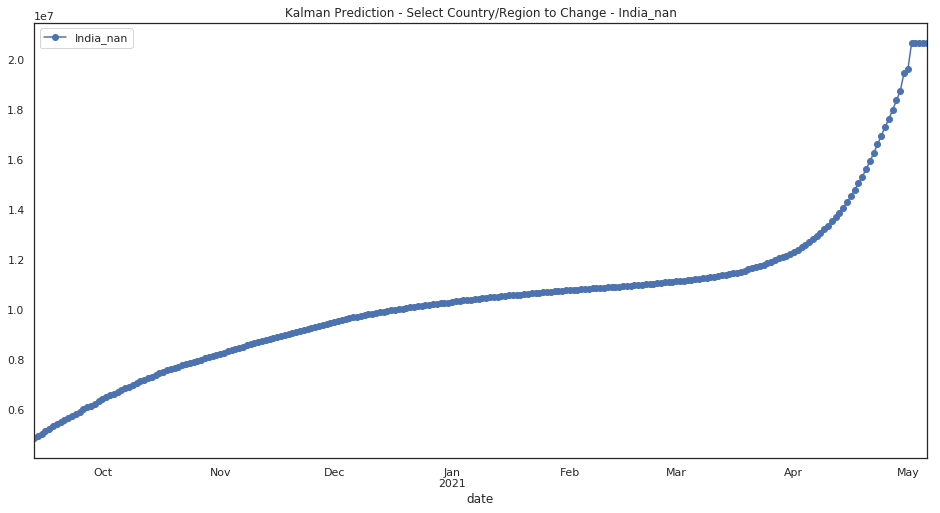

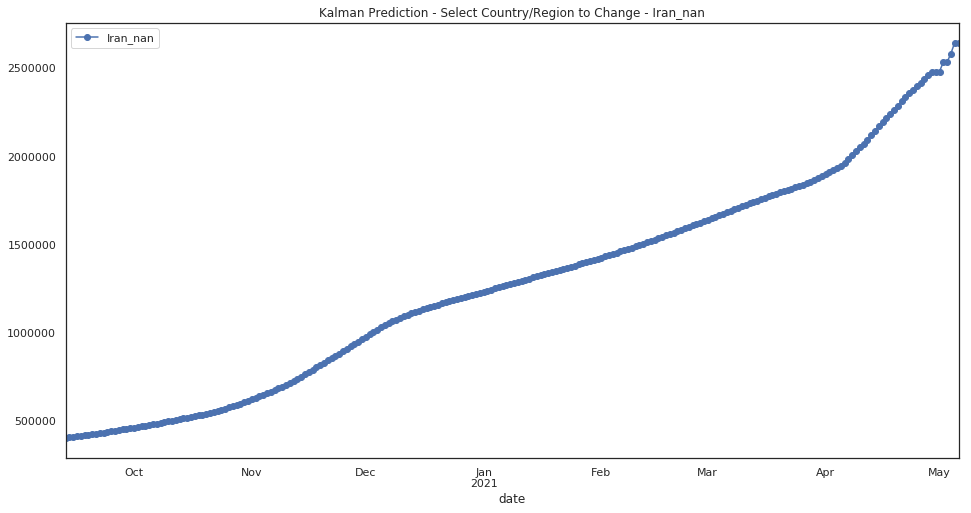

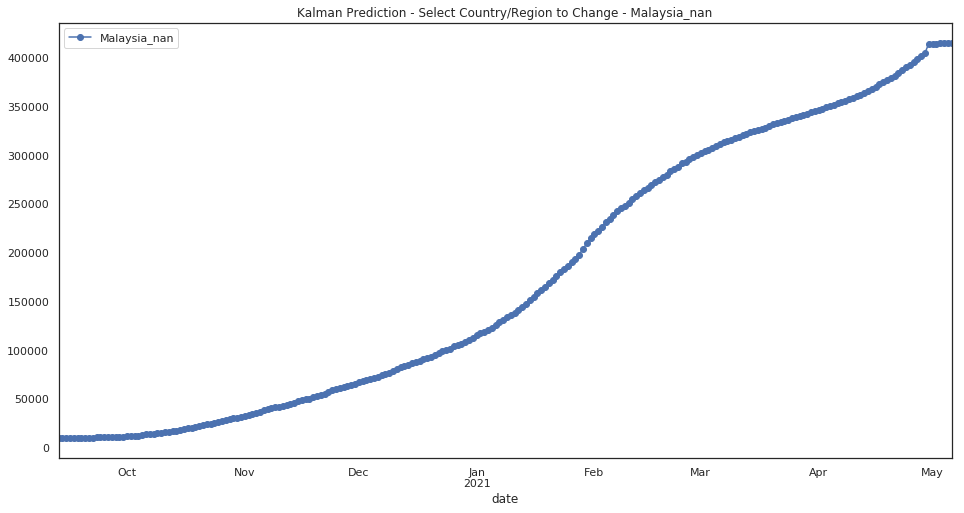

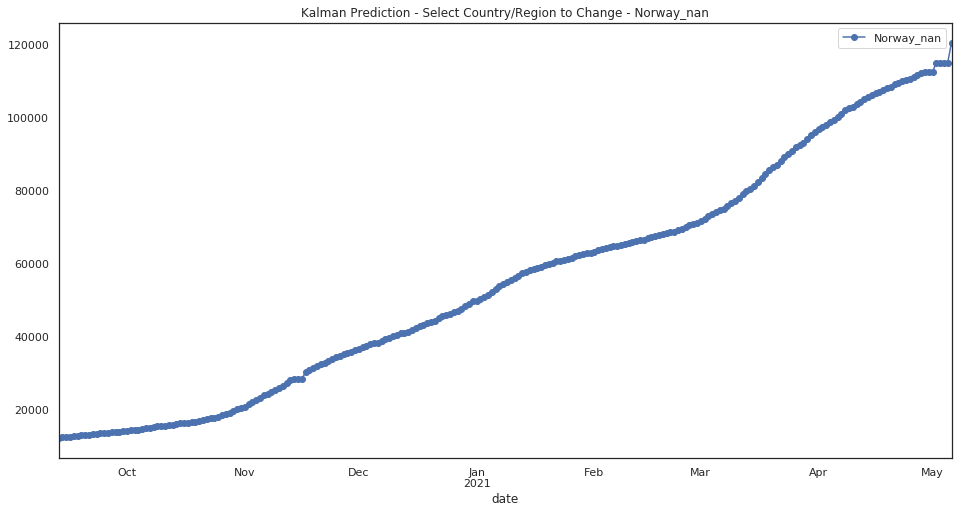

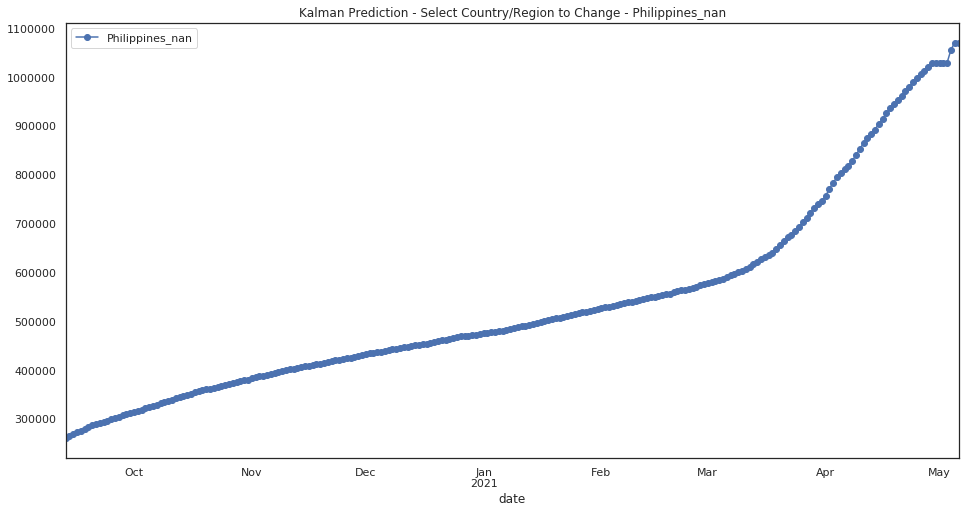

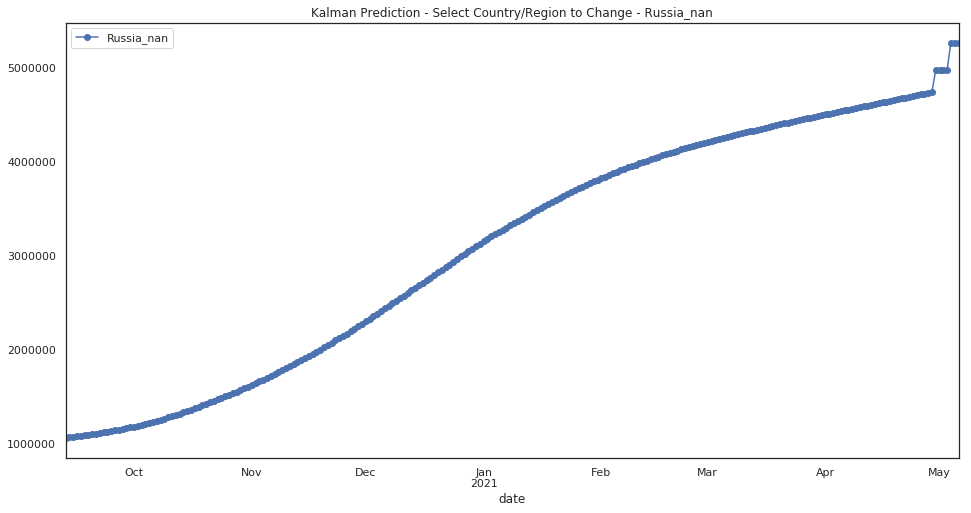

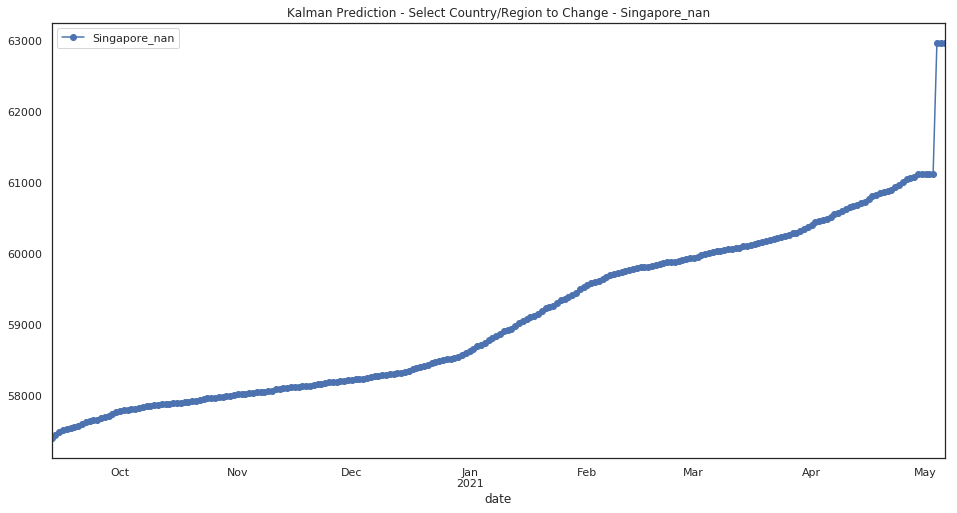

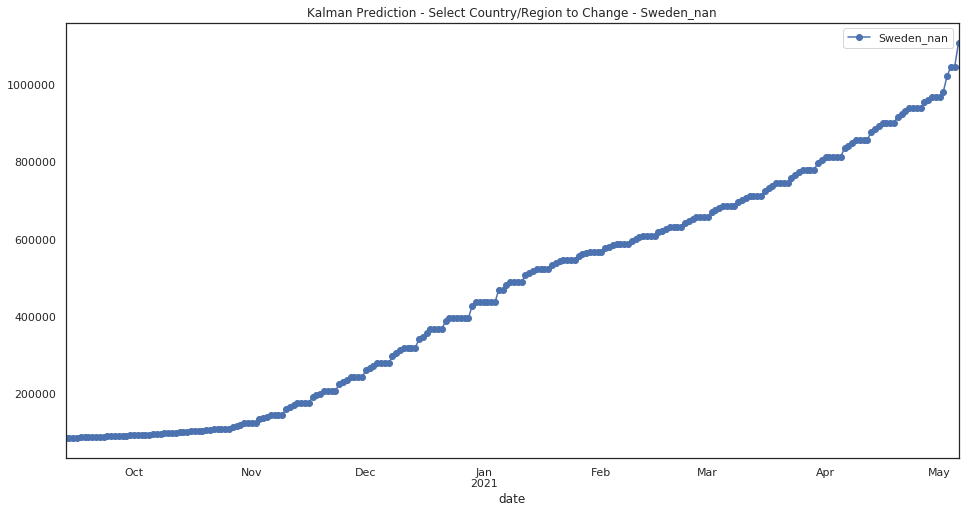

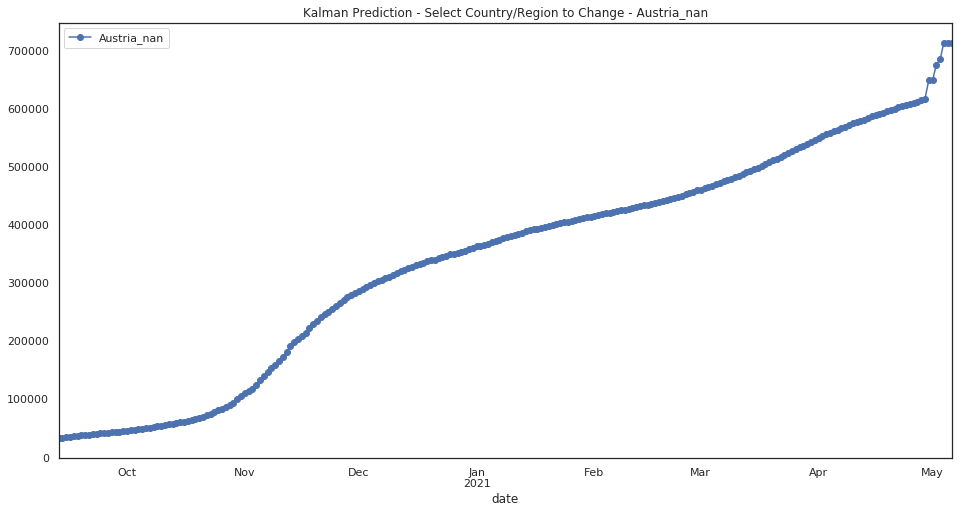

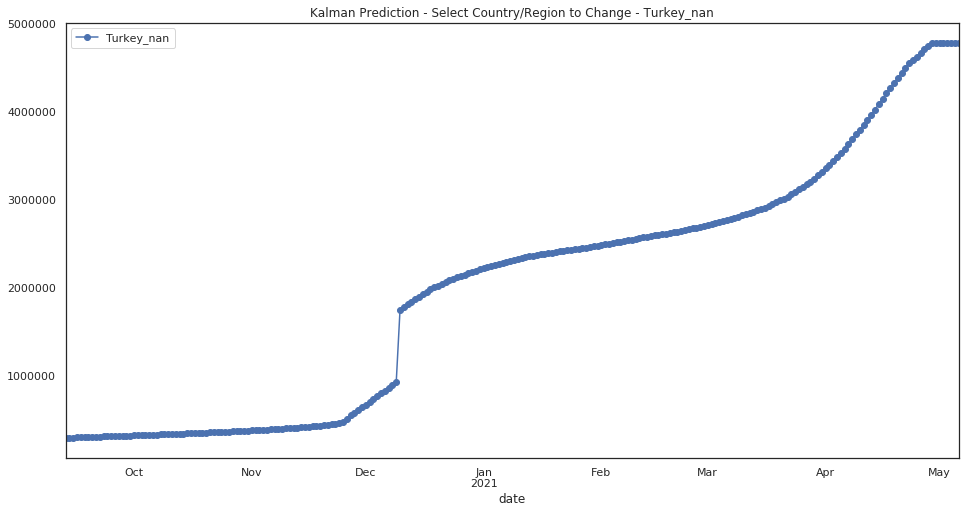

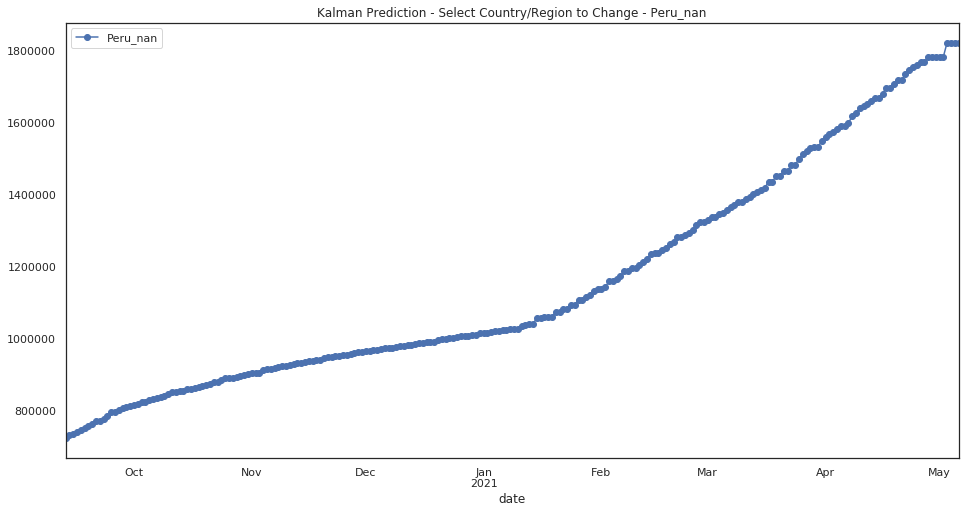

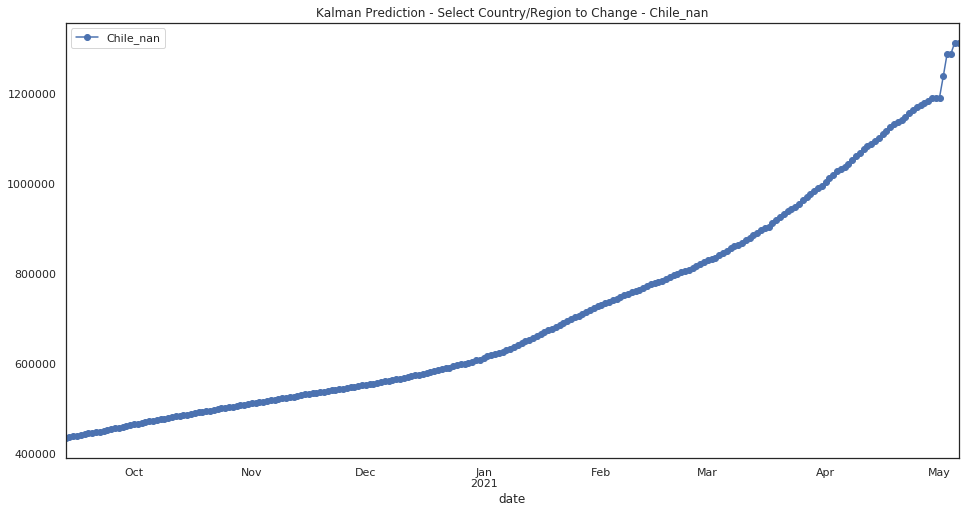

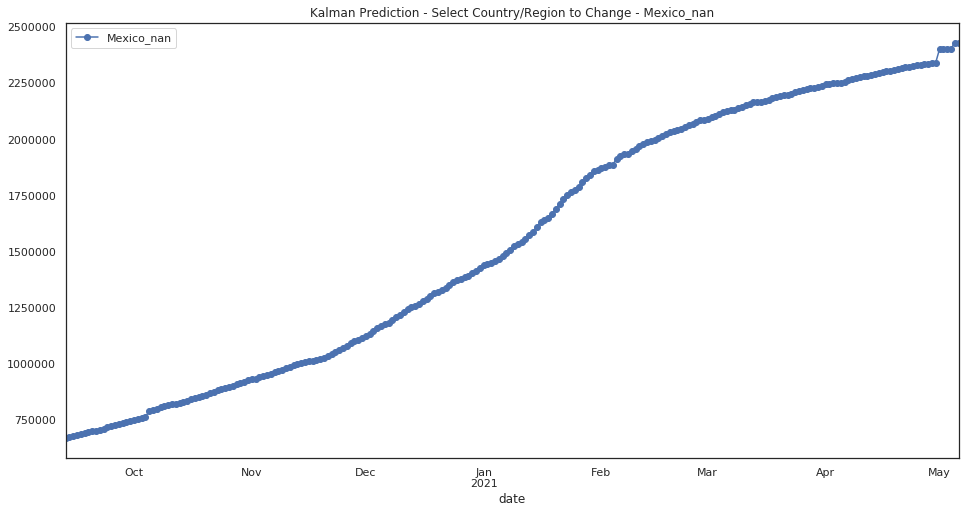

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-05-06 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      33349350.0
India_nan                                           NaN      20693837.0
Brazil_nan                                          NaN      16382766.0
France_nan                                          NaN       5893668.0
Russia_nan                                          NaN       5268228.0
Turkey_nan                                          NaN       4788700.0
United Kingdom_nan                                  NaN       4771741.0
Italy_nan                                           NaN       4477585.0
Spain_nan                                           NaN       3551797.0
Germany_nan                                         NaN       3532181.0
Colombia_nan                                        NaN       3000556.0
Argentina_nan                                       NaN       2990297.0
Poland_nan                                          NaN       2871729.0
Iran_nan                                            NaN       2643825.0
Mexico_nan                                          NaN       2430341.0
Ukraine_nan                                         NaN       2222815.0
Peru_nan                                            NaN       1823139.0
Indonesia_nan                                       NaN       1769213.0
South Africa_nan                                    NaN       1726524.0
Czechia_nan                                         NaN       1701390.0
Netherlands_nan                                     NaN       1597912.0
Chile_nan                                           NaN       1313184.0
Iraq_nan                                            NaN       1141973.0
Romania_nan                                         NaN       1137365.0
Sweden_nan                                          NaN       1108004.0
Philippines_nan                                     NaN       1071019.0
Portugal_nan                                        NaN       1011061.0
Pakistan_nan                                        NaN        992662.0
Belgium_nan                                         NaN        991441.0
Israel_nan                                          NaN        887622.0
...                                                 ...             ...
Canada_Prince Edward Island                         NaN           184.0
Grenada_nan                                         NaN           169.0
China_Guizhou                                       NaN           154.0
Fiji_nan                                            NaN           148.0
France_New Caledonia                                NaN           134.0
United Kingdom_Anguilla                             NaN           134.0
Australia_Australian Capital Territory              NaN           125.0
Canada_Yukon                                        NaN            87.0
China_Ningxia                                       NaN            78.0
United Kingdom_Falkland Islands (Malvinas)          NaN            66.0
Canada_Northwest Territories                        NaN            61.0
China_Macau                                         NaN            50.0
Saint Kitts and Nevis_nan                           NaN            47.0
Denmark_Greenland                                   NaN            32.0
Holy See_nan                                        NaN            28.0
France_Saint Pierre and Miquelon                    NaN            25.0
United Kingdom_Montserrat                           NaN            22.0
Solomon Islands_nan                                 NaN            21.0
China_Qinghai                                       NaN            19.0
Canada_Repatriated Travellers                       NaN            16.0
Canada_Grand Princess                               NaN            13.0
MS Zaandam_nan                                      NaN             9.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Marshall Islands_nan                                NaN             4.0
Vanuatu_nan           

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-09-13          51297.0      27697.0      59524.0      19064.0   
2020-09-14          51346.0      27841.0      59733.0      19145.0   
2020-09-15          38772.0      11520.0      48496.0       1438.0   
2020-09-16          38815.0      11672.0      48734.0       1438.0   
2020-09-17          38855.0      11816.0      48972.0       1483.0   
2020-09-18          38872.0      11948.0      49194.0       1483.0   
2020-09-19          38897.0      12073.0      49413.0       1564.0   
2020-09-20          38919.0      12226.0      49623.0       1564.0   
2020-09-21          39169.0      12489.0      50082.0       1853.0   
2020-09-22          39195.0      12640.0      50274.0       1681.0   
2020-09-23          39242.0      12781.0      50461.0       1963.0   
2020-09-24          39262.0      12917.0      50641.0       1753.0   
2020-09-25          39278.0      13026.0      50818.0       1986.0   
2020-09-26          39285.0      13147.0      50980.0       1836.0   
2020-09-27          39313.0      13269.0      51133.0       1998.0   
2020-09-28          39334.0      13396.0      51280.0       2110.0   
2020-09-29          39349.0      13501.0      51433.0       1966.0   
2020-09-30          39365.0      13641.0      51597.0       2236.0   
2020-10-01          39381.0      13796.0      51760.0       2050.0   
2020-10-02          39389.0      13934.0      51920.0       2242.0   
2020-10-03          39395.0      14092.0      52070.0       2110.0   
2020-10-04          39433.0      14251.0      52210.0       2216.0   
2020-10-05          39511.0      14397.0      52343.0       2440.0   
2020-10-06          39581.0      14555.0      52471.0       2370.0   
2020-10-07          39647.0      14705.0      52592.0       2823.0   
2020-10-08          39713.0      14872.0      52727.0       2568.0   
2020-10-09          39785.0      15039.0      52876.0       2888.0   
2020-10-10          39801.0      15208.0      53017.0       2696.0   
2020-10-11          39880.0      15379.0      53150.0       2841.0   
2020-10-12          39954.0      15547.0      53386.0       3099.0   
...                     ...          ...          ...          ...   
2021-04-08          57034.0     127382.0     118189.0      12363.0   
2021-04-09          57108.0     127699.0     118316.0      12409.0   
2021-04-10          57227.0     128051.0     118450.0      12456.0   
2021-04-11          57262.0     128337.0     118582.0      12497.0   
2021-04-12          57318.0     128437.0     118716.0      12545.0   
2021-04-13          57442.0     128613.0     118862.0      12581.0   
2021-04-14          57572.0     128846.0     119044.0      12614.0   
2021-04-15          57634.0     129012.0     119219.0      12641.0   
2021-04-16          57692.0     129189.0     119395.0      12641.0   
2021-04-17          57798.0     129348.0     119564.0      12712.0   
2021-04-18          57880.0     129486.0     119712.0      12771.0   
2021-04-19          57974.0     129594.0     119869.0      12805.0   
2021-04-20          58114.0     129715.0     120052.0      12805.0   
2021-04-21          58293.0     129876.0     120242.0      12874.0   
2021-04-22          58414.0     130011.0     120430.0      12917.0   
2021-04-23          58610.0     130167.0     120631.0      12942.0   
2021-04-24          58823.0     130318.0     120811.0      13007.0   
2021-04-25          58936.0     130442.0     120986.0      13024.0   
2021-04-26          59087.0     130537.0     121177.0      13060.0   
2021-04-27          59292.0     130612.0     121402.0      13083.0   
2021-04-28          59450.0     130757.0     121653.0      13121.0   
2021-04-29          59642.0     130874.0     121934.0      13148.0   
2021-04-30          60651.0     134584.0     121991.0      13198.0   
2021-05-01          60987.0     136655.0     125401.0      13198.0   
2021-05-02

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Russia_nan',
 'Turkey_nan',
 'United Kingdom_nan',
 'Italy_nan',
 'Spain_nan',
 'Germany_nan',
 'Colombia_nan',
 'Argentina_nan',
 'Poland_nan',
 'Iran_nan',
 'Mexico_nan',
 'Ukraine_nan',
 'Peru_nan',
 'Indonesia_nan',
 'South Africa_nan',
 'Czechia_nan',
 'Netherlands_nan',
 'Chile_nan',
 'Iraq_nan',
 'Romania_nan',
 'Sweden_nan',
 'Philippines_nan',
 'Portugal_nan',
 'Pakistan_nan',
 'Belgium_nan',
 'Israel_nan',
 'Hungary_nan',
 'Bangladesh_nan',
 'Serbia_nan',
 'Jordan_nan',
 'Austria_nan',
 'Switzerland_nan',
 'Japan_nan',
 'Morocco_nan',
 'Lebanon_nan',
 'United Arab Emirates_nan',
 'Canada_Ontario',
 'Saudi Arabia_nan',
 'Slovakia_nan',
 'Ecuador_nan',
 'Bulgaria_nan',
 'Malaysia_nan',
 'Kazakhstan_nan',
 'Canada_Quebec',
 'Panama_nan',
 'Greece_nan',
 'Belarus_nan',
 'Croatia_nan',
 'Georgia_nan',
 'Nepal_nan',
 'Kuwait_nan',
 'Bolivia_nan',
 'Tunisia_nan',
 'Azerbaijan_nan',
 'West Bank and Gaza_nan',
 'Parag

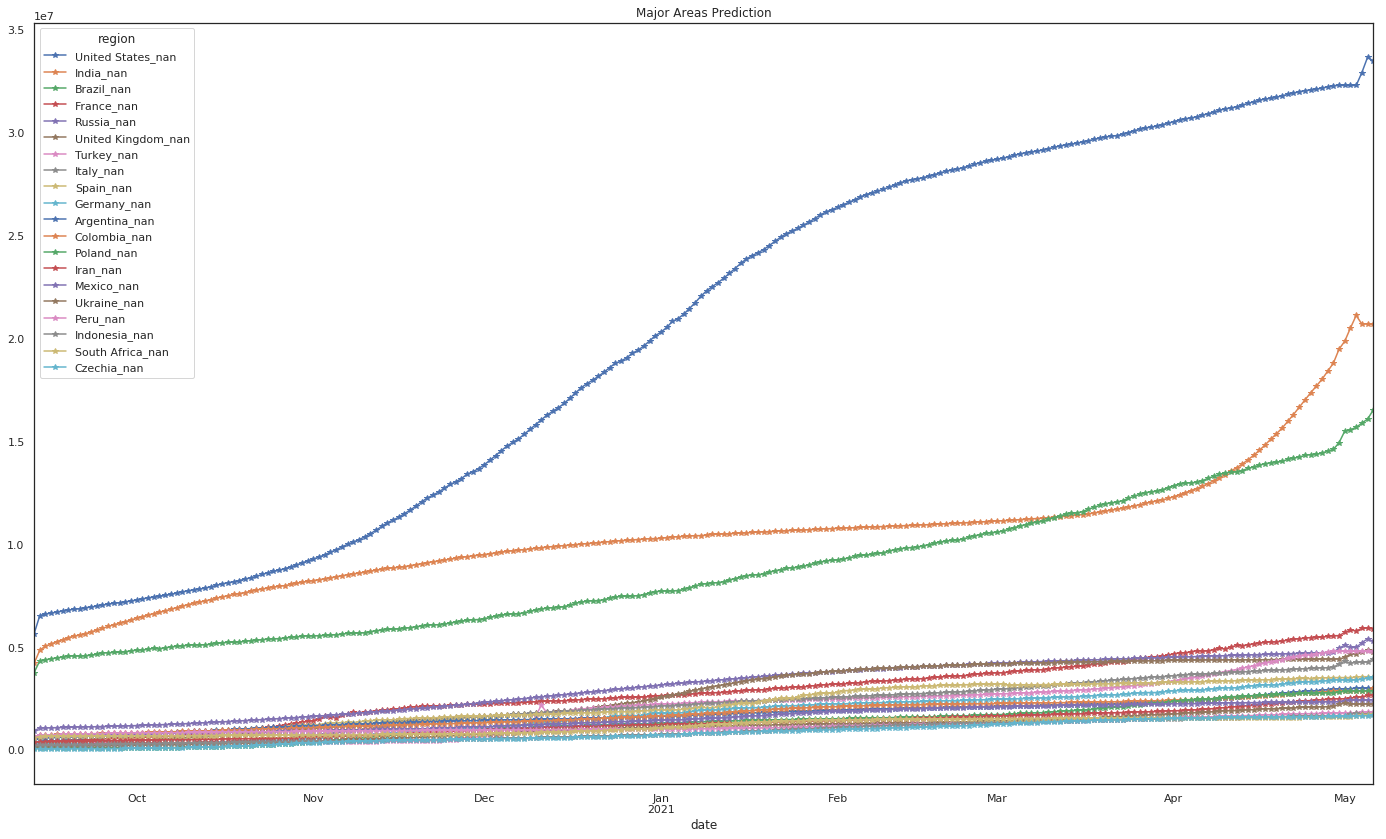

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

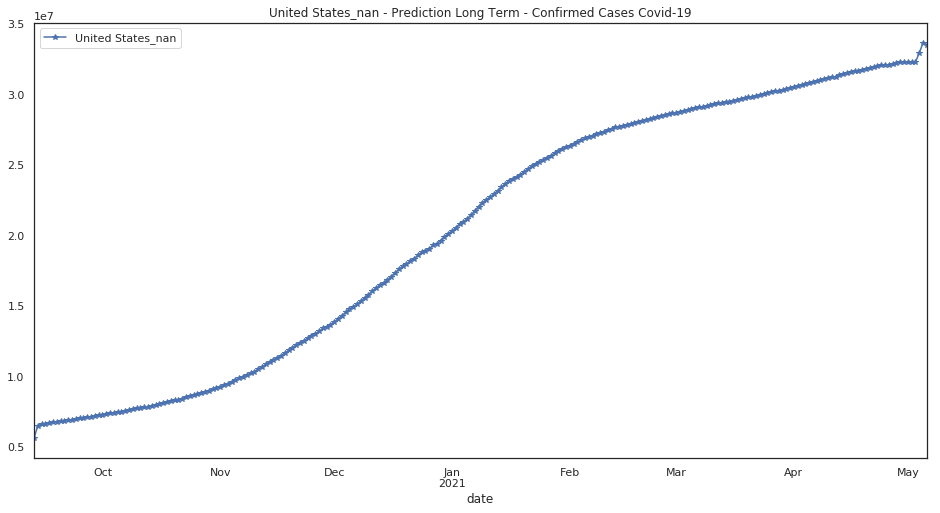

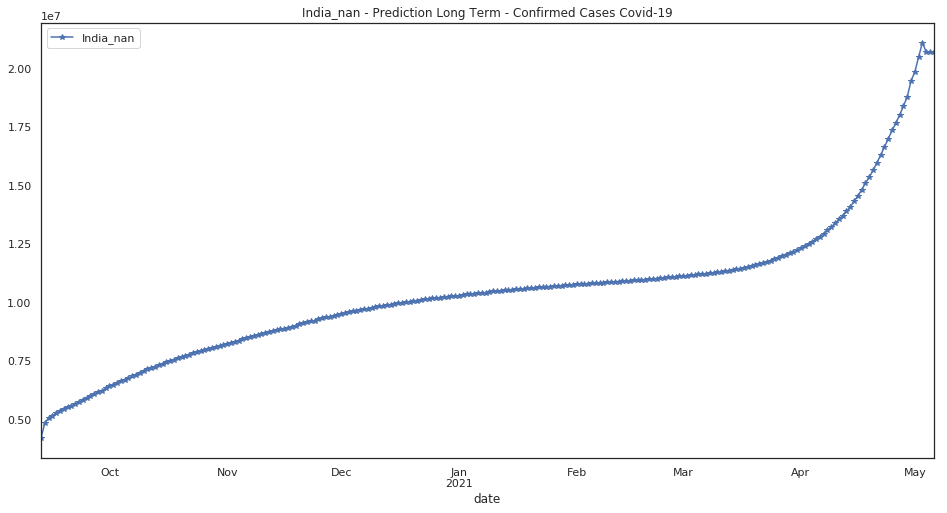

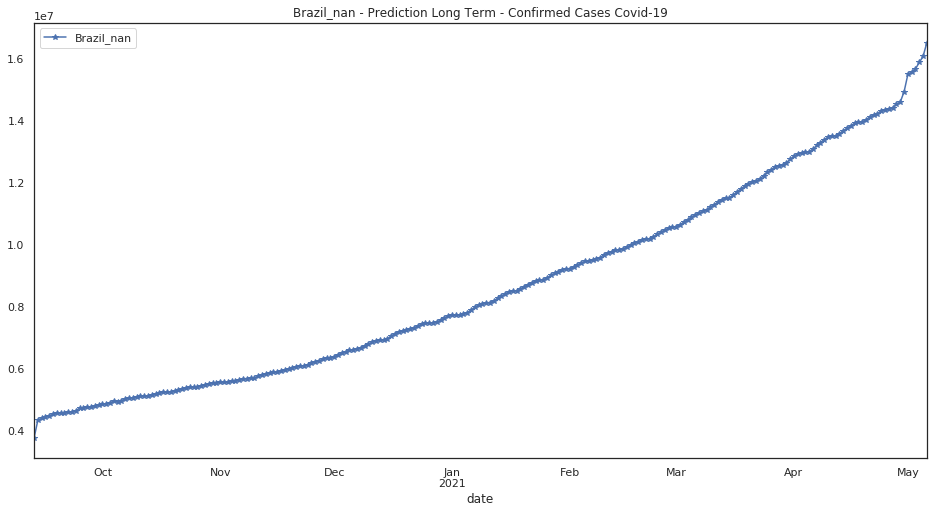

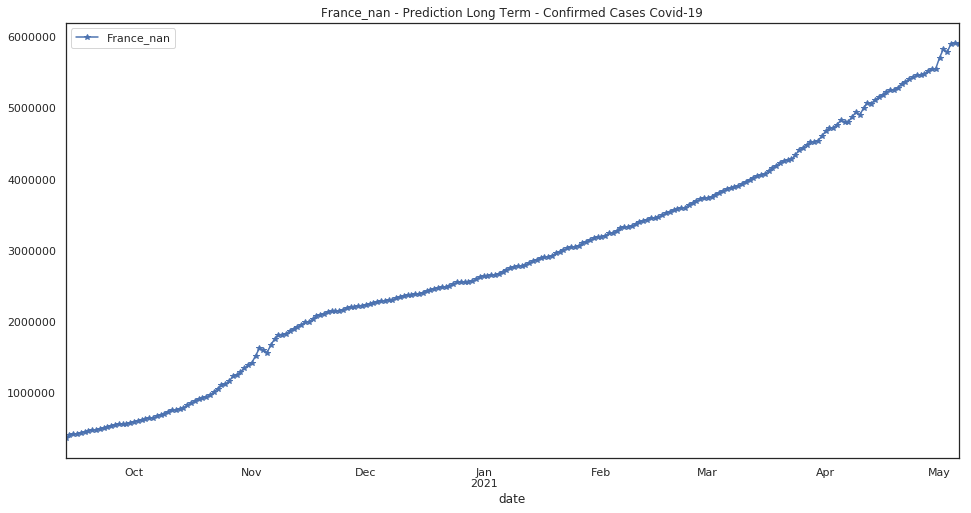

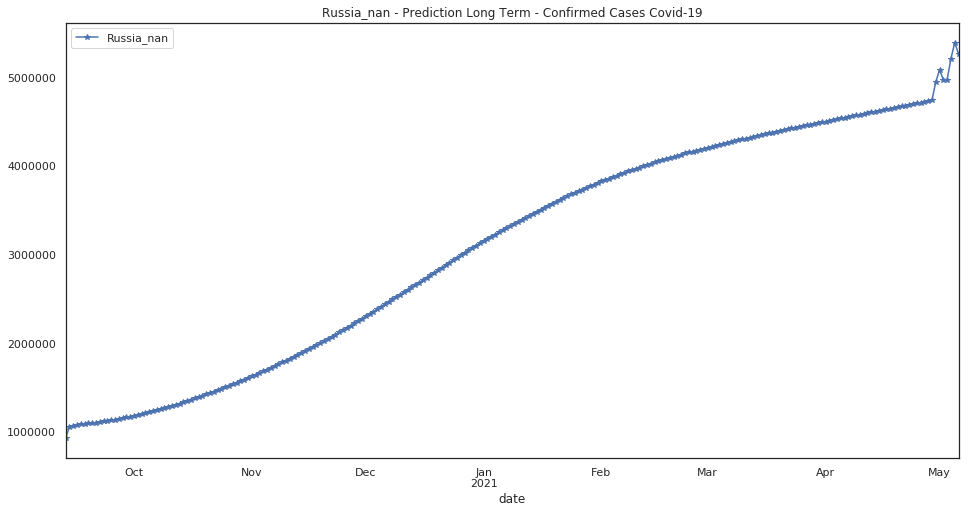

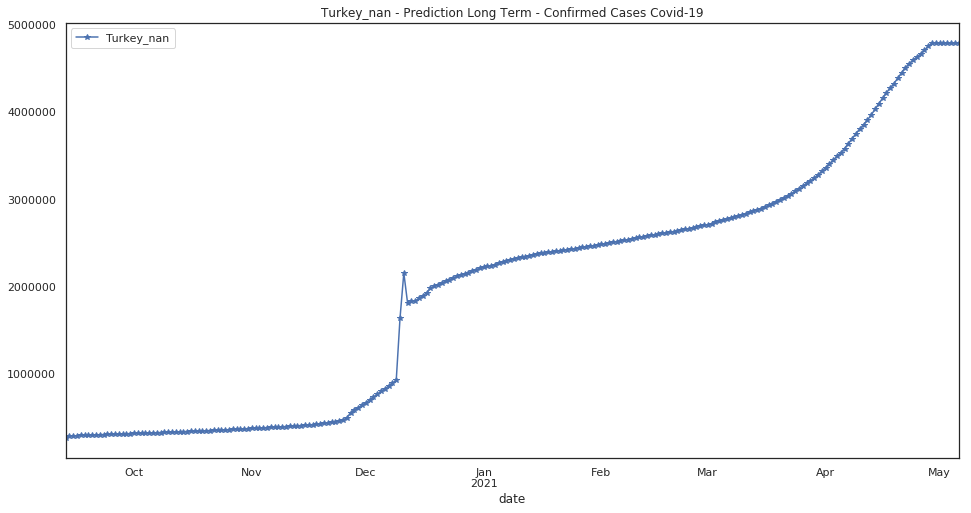

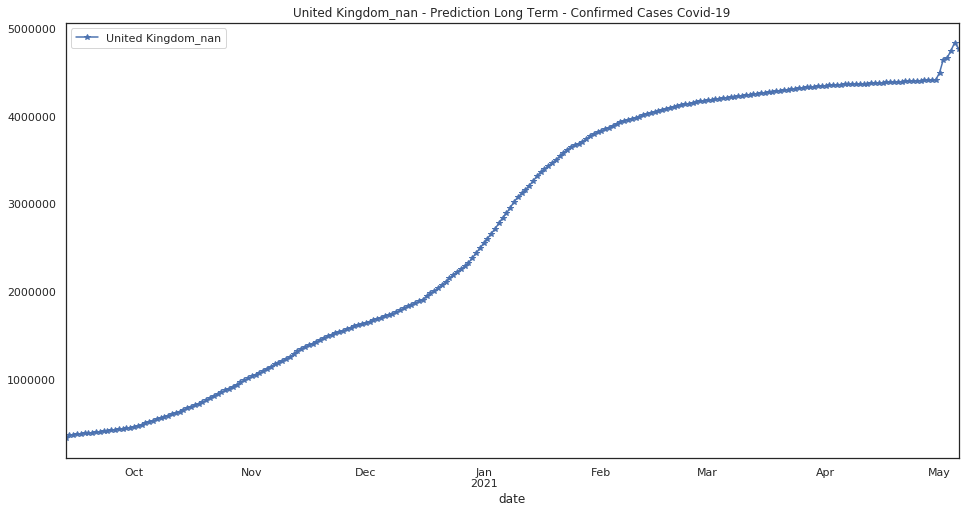

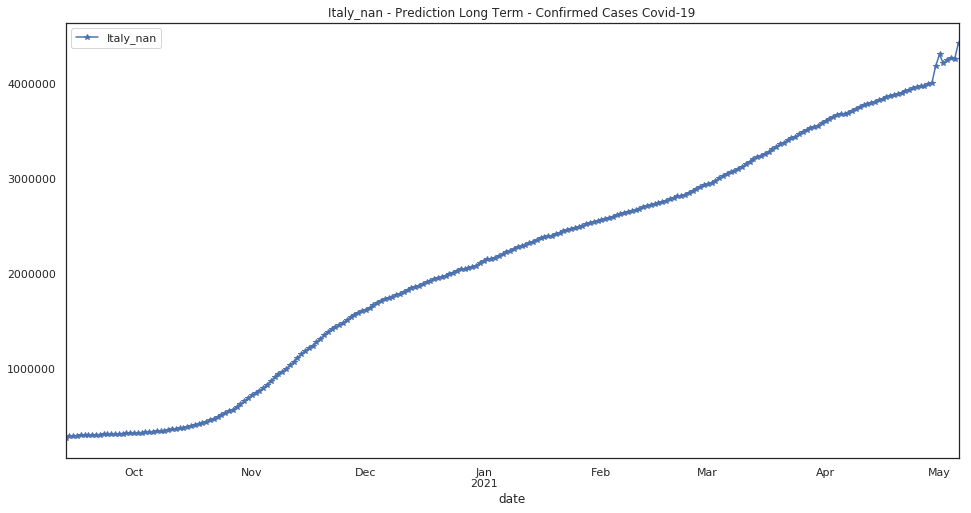

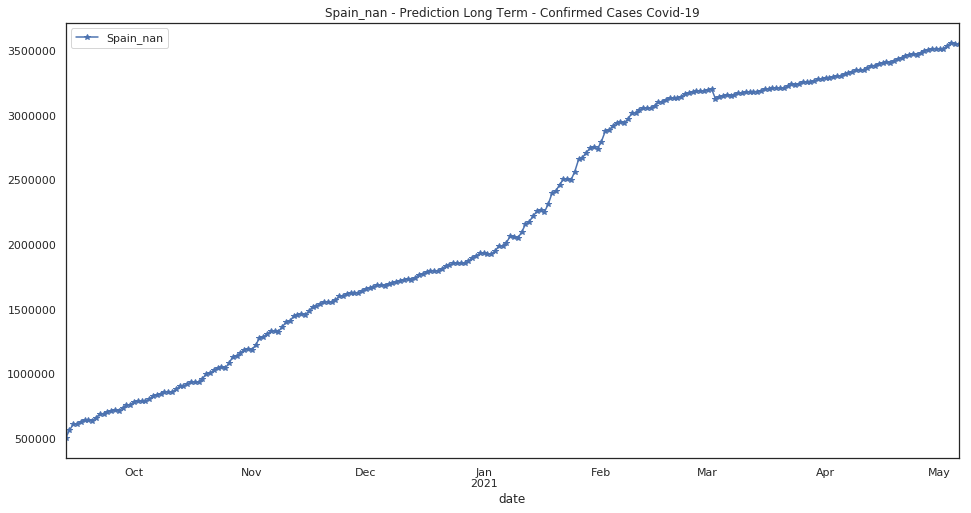

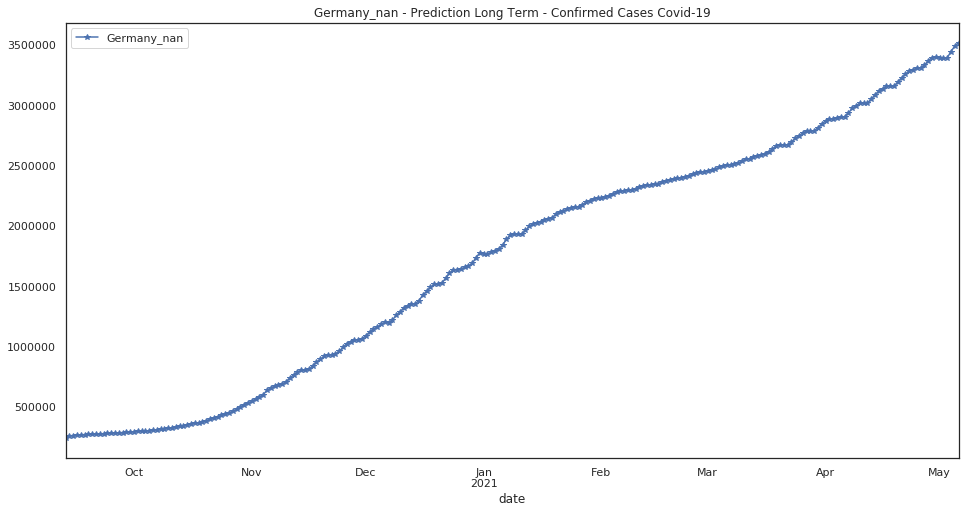

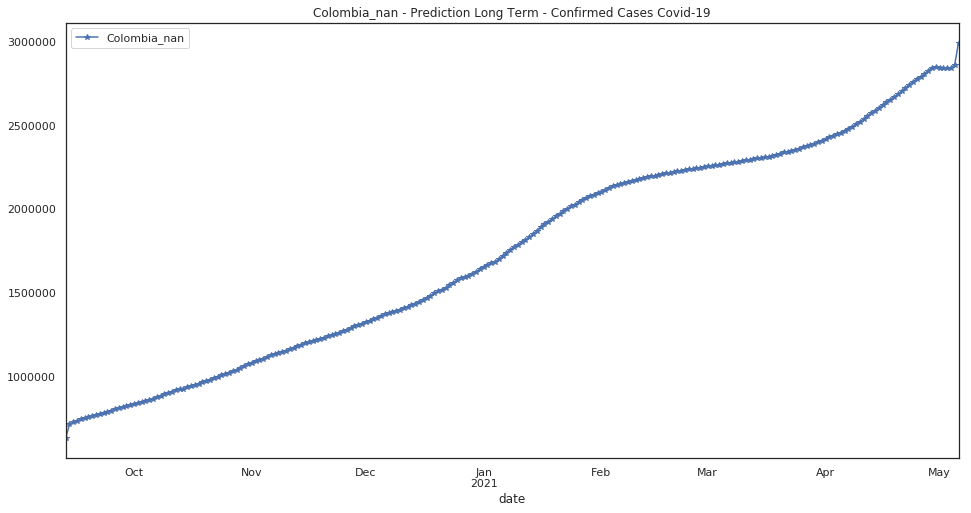

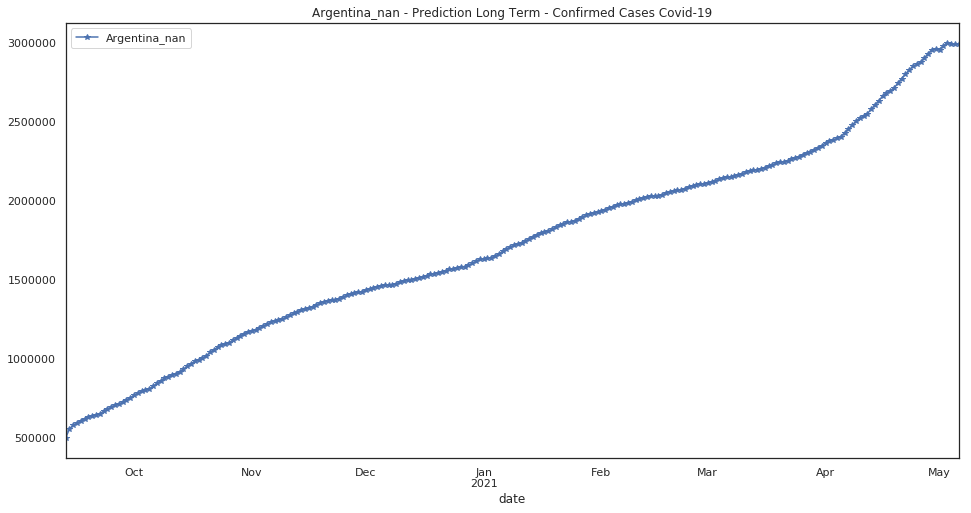

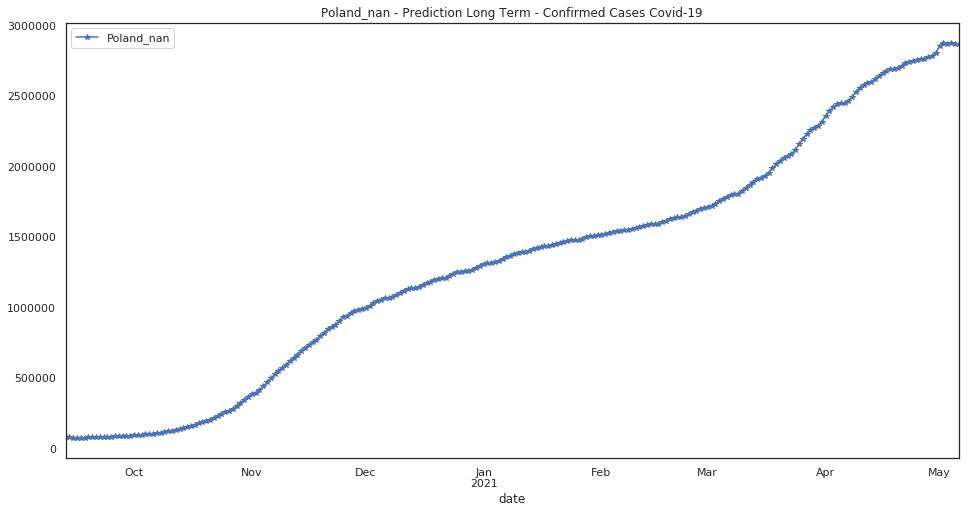

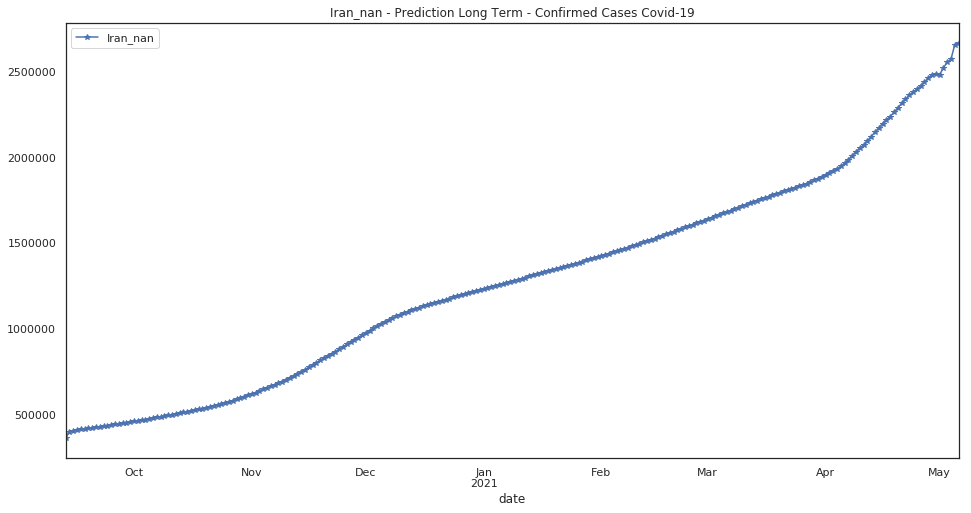

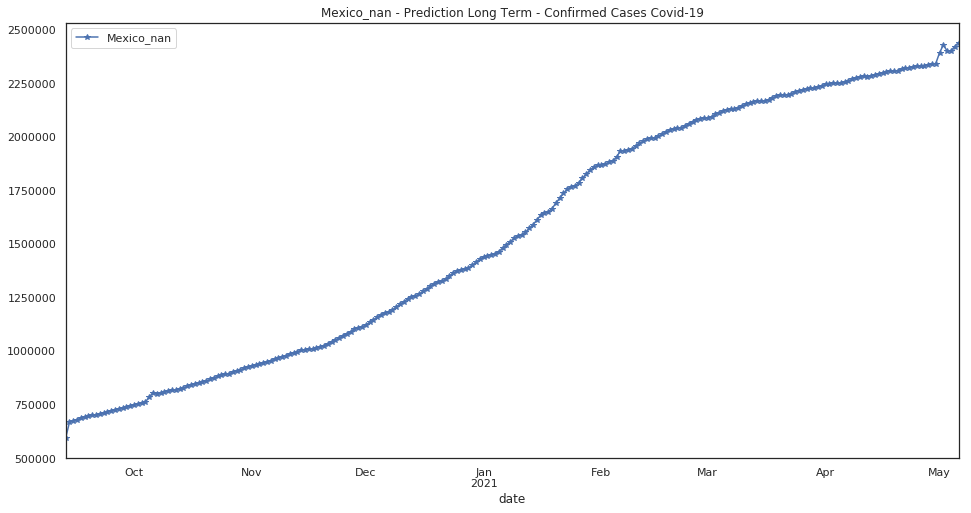

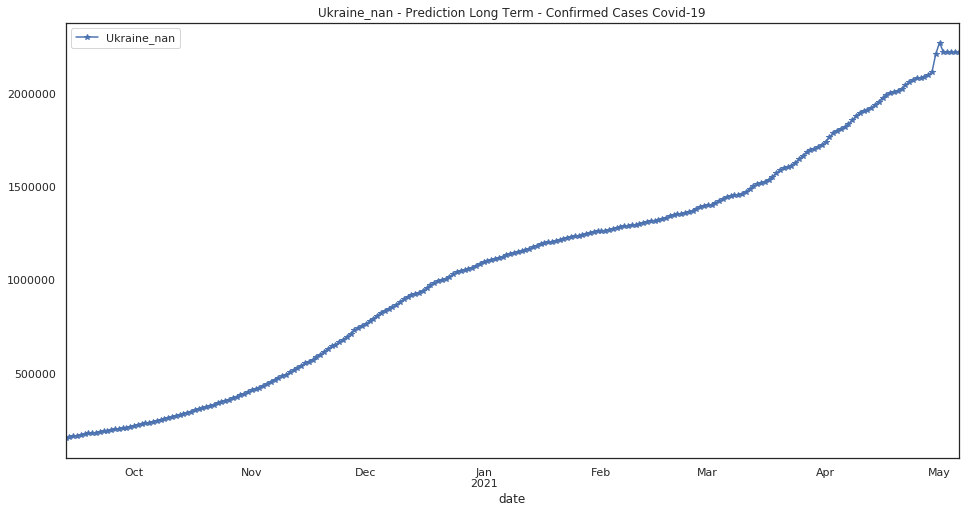

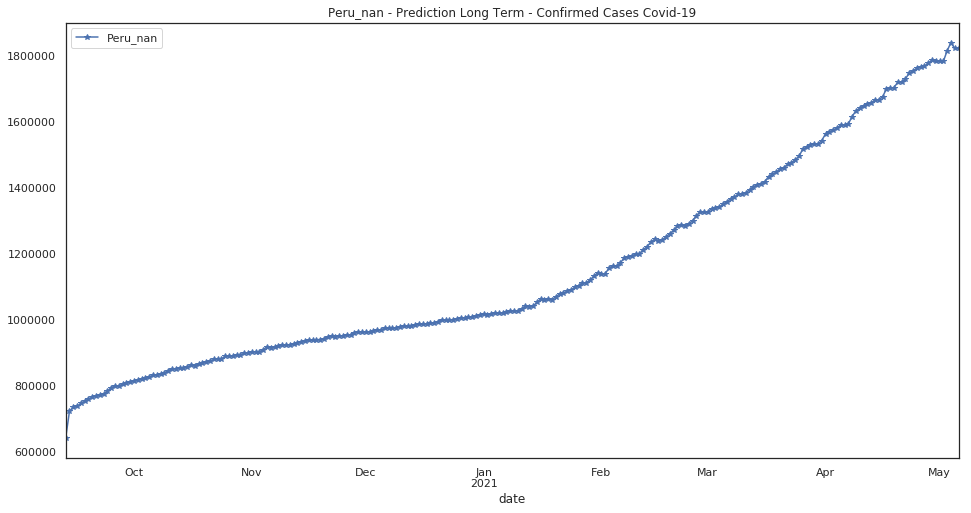

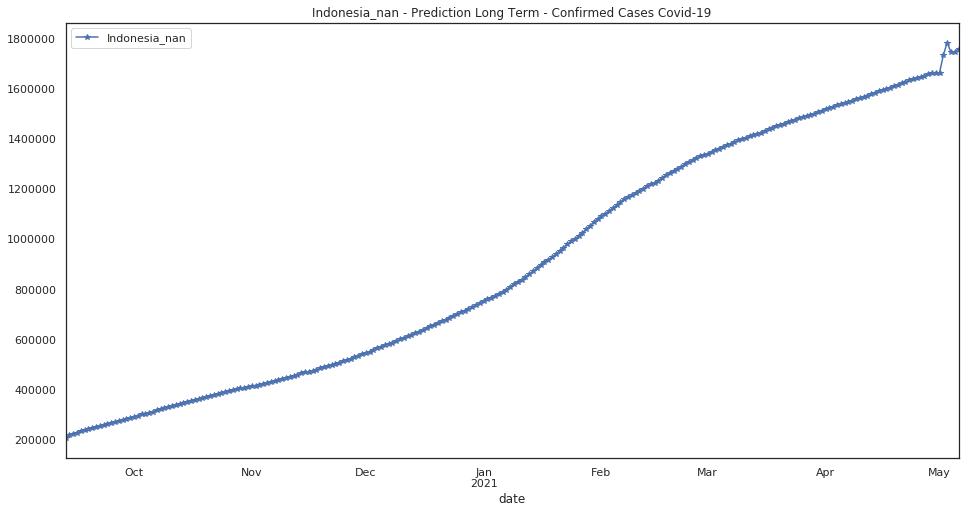

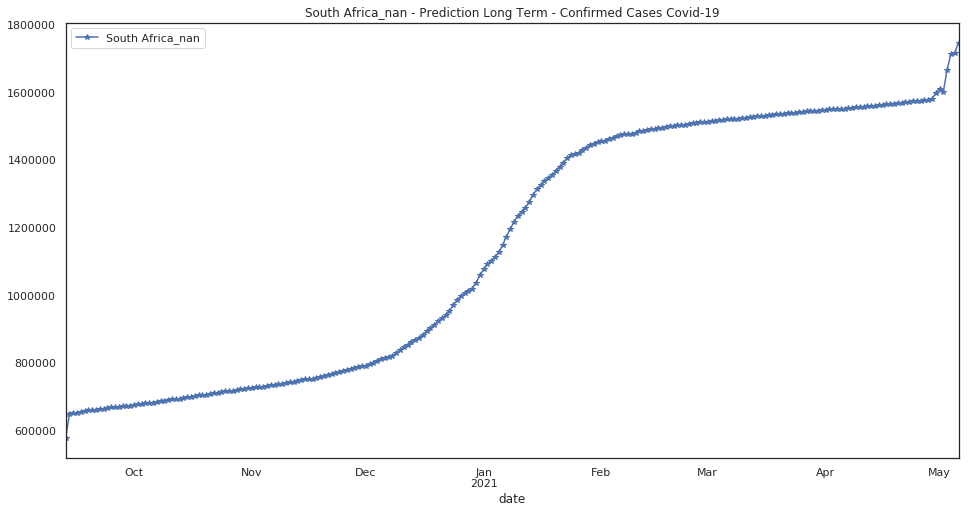

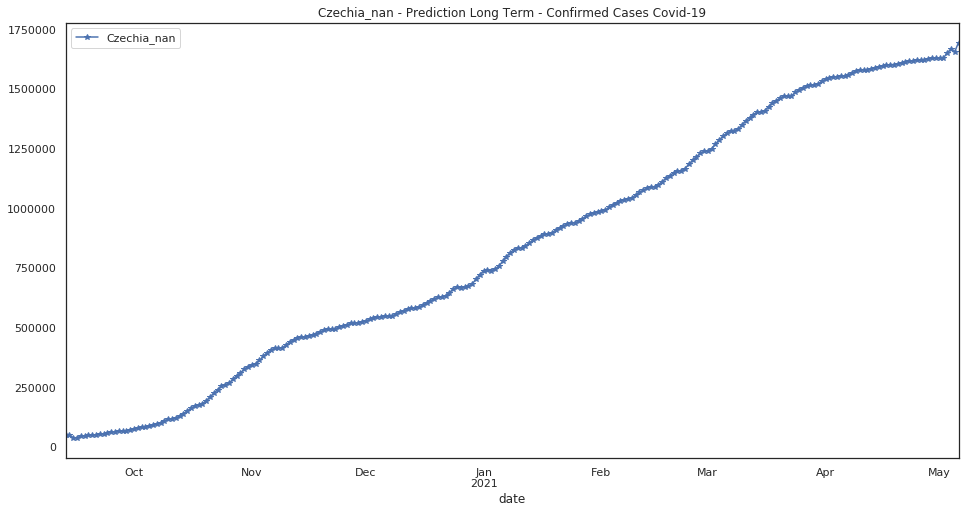

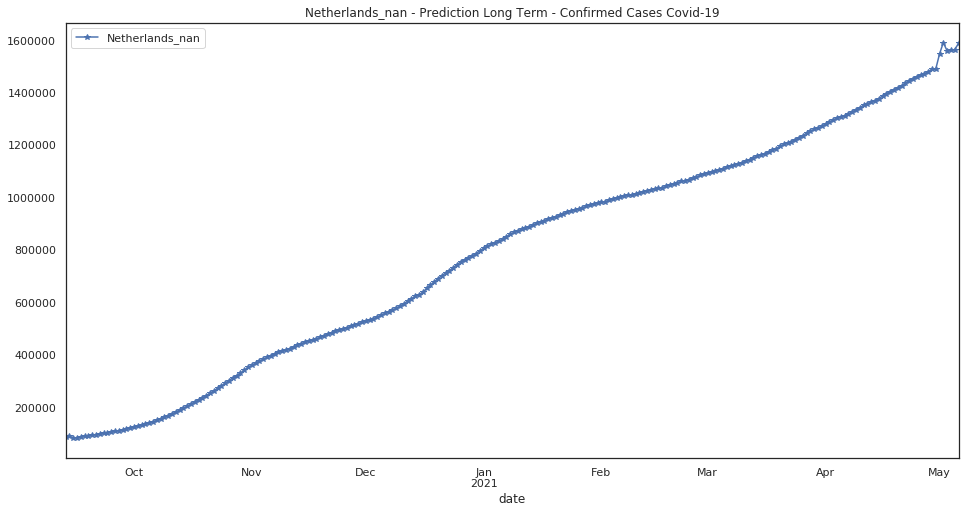

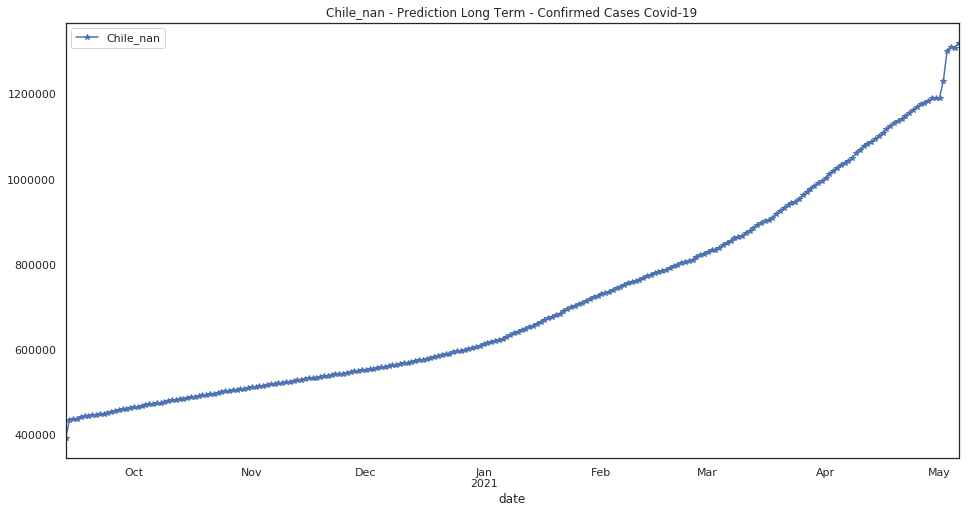

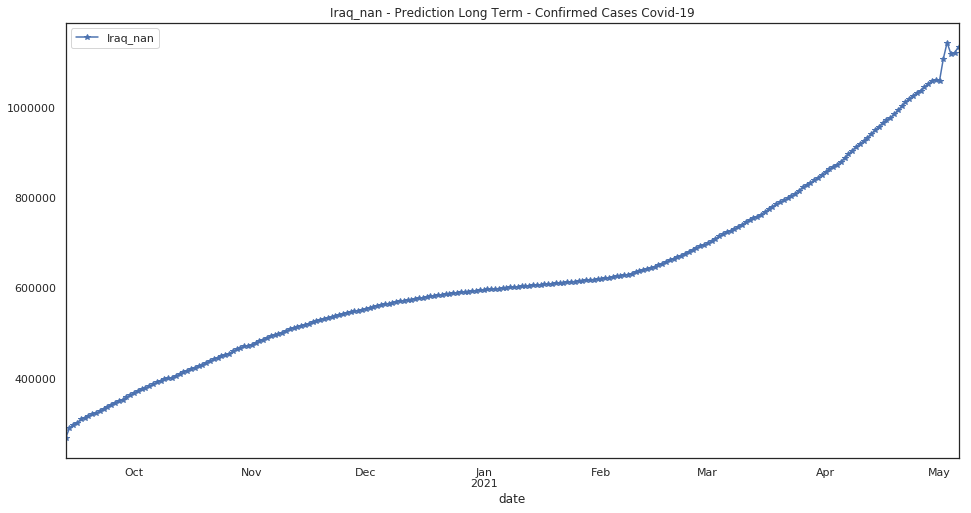

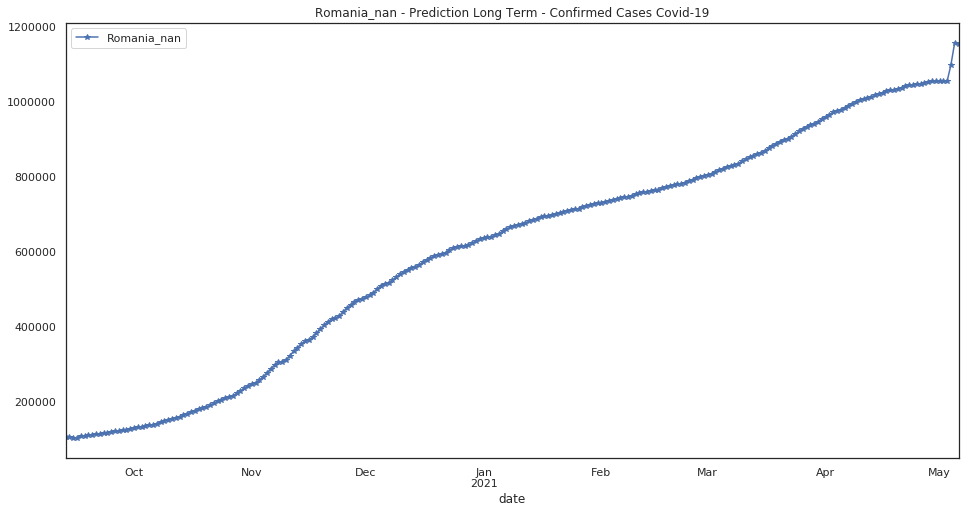

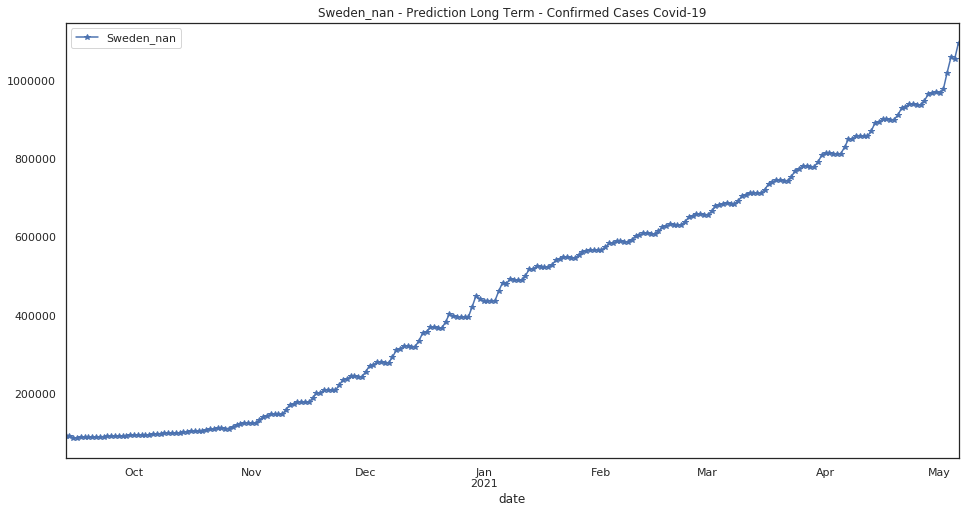

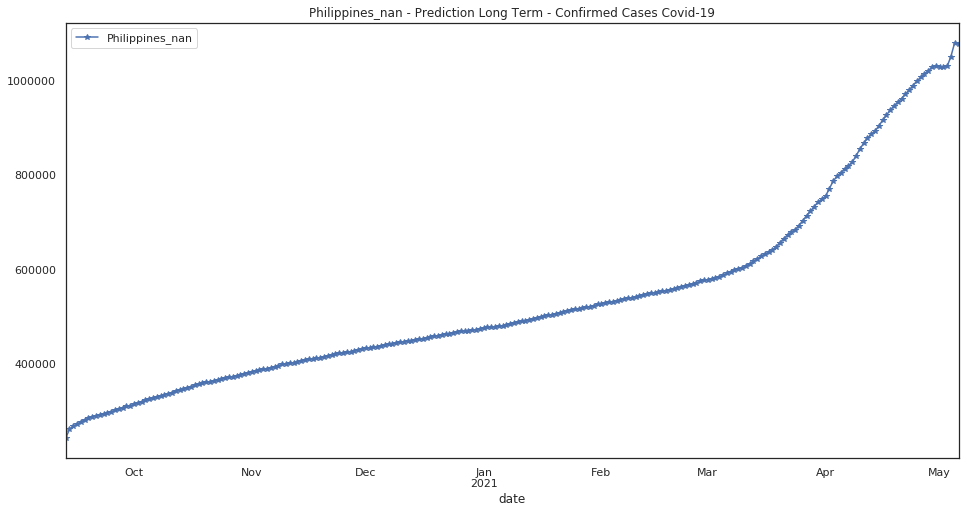

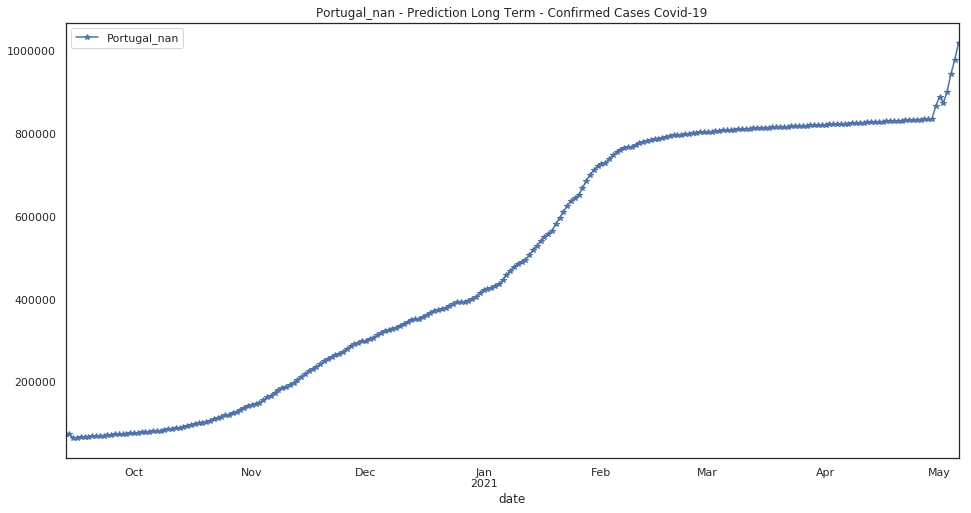

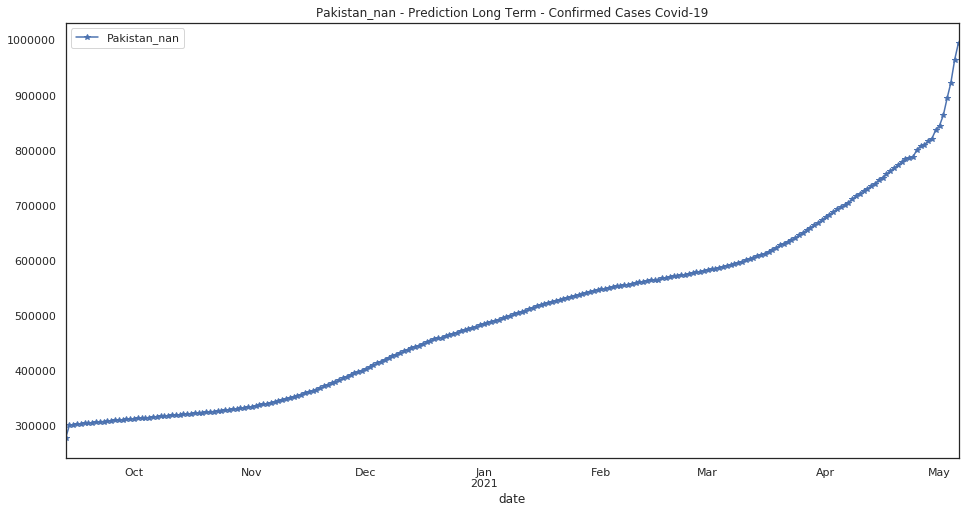

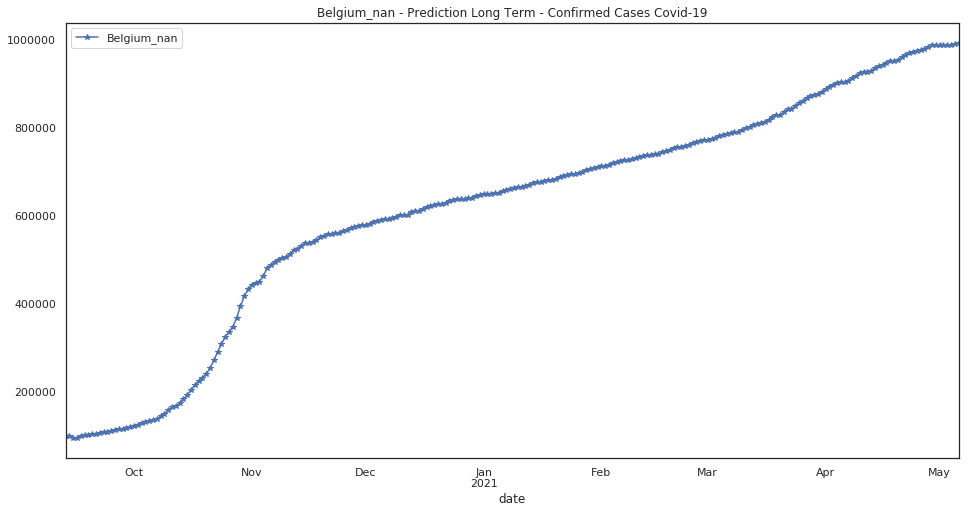

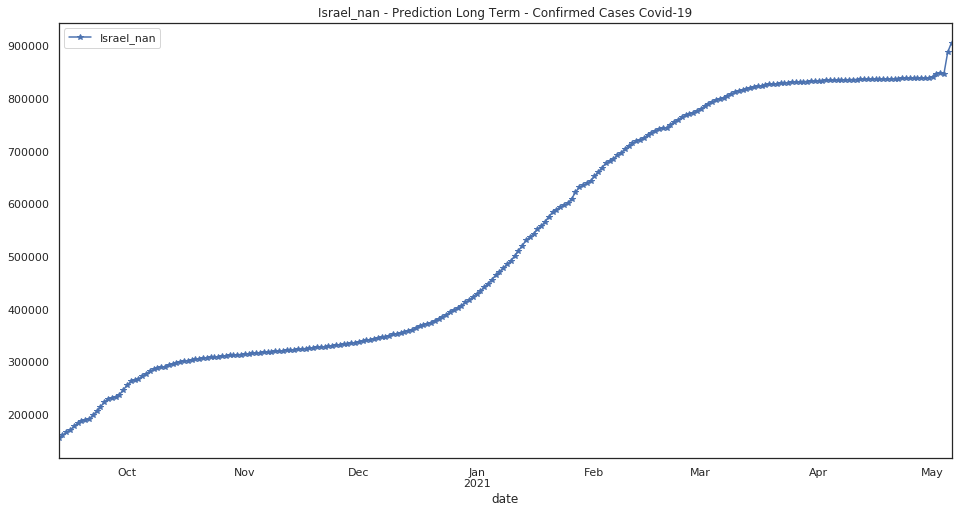

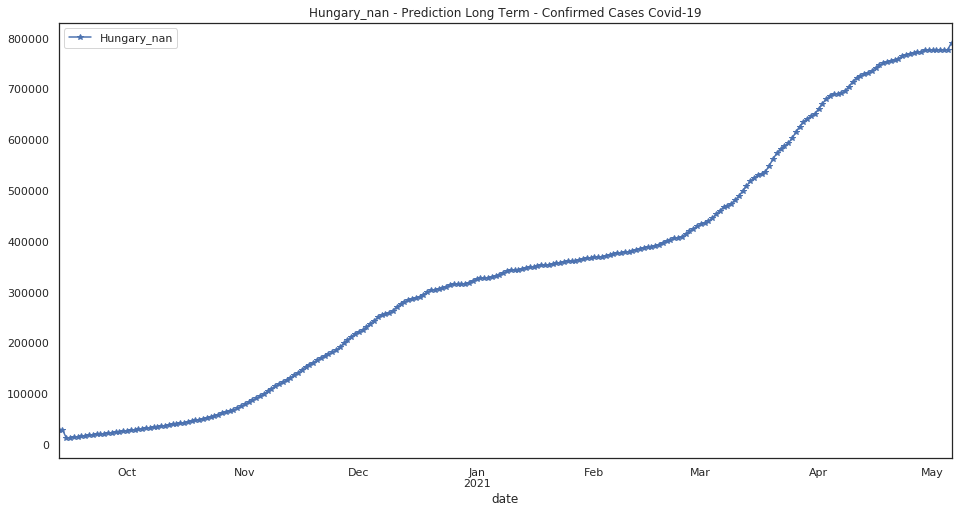

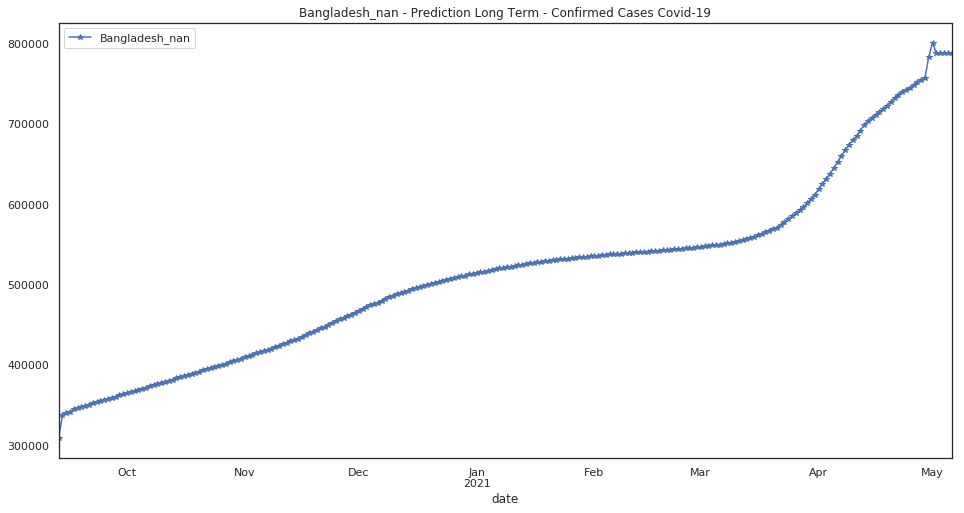

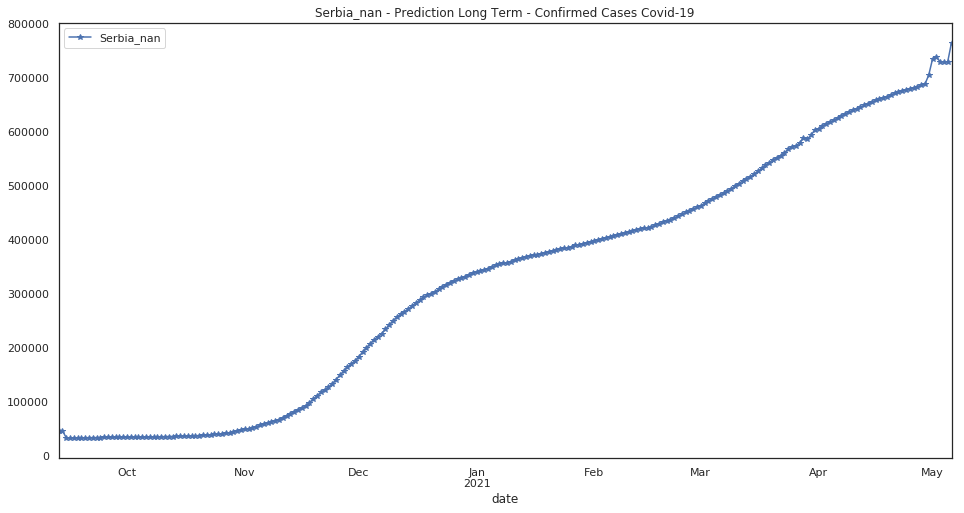

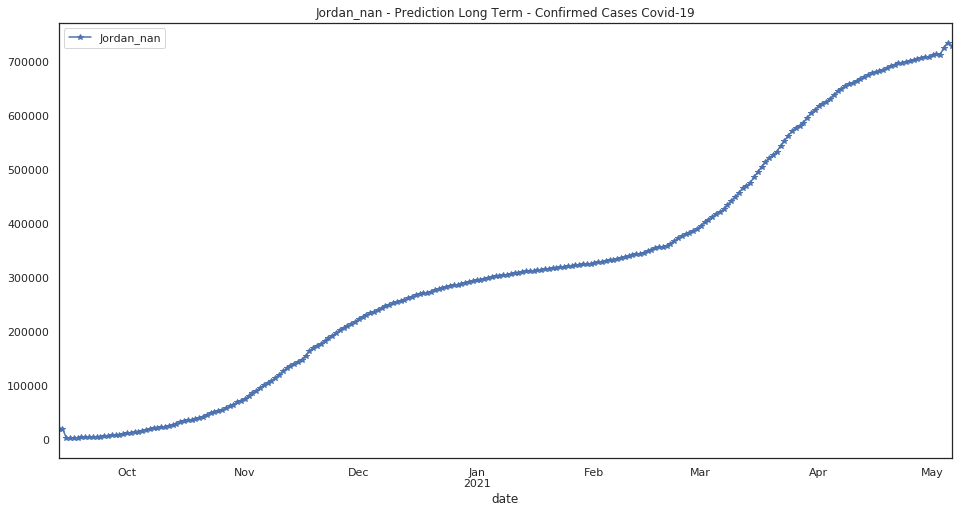

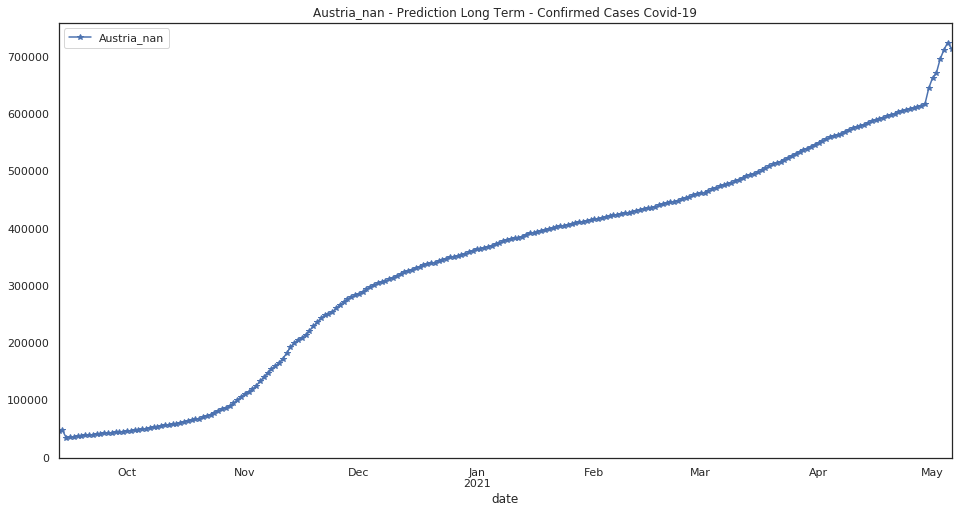

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

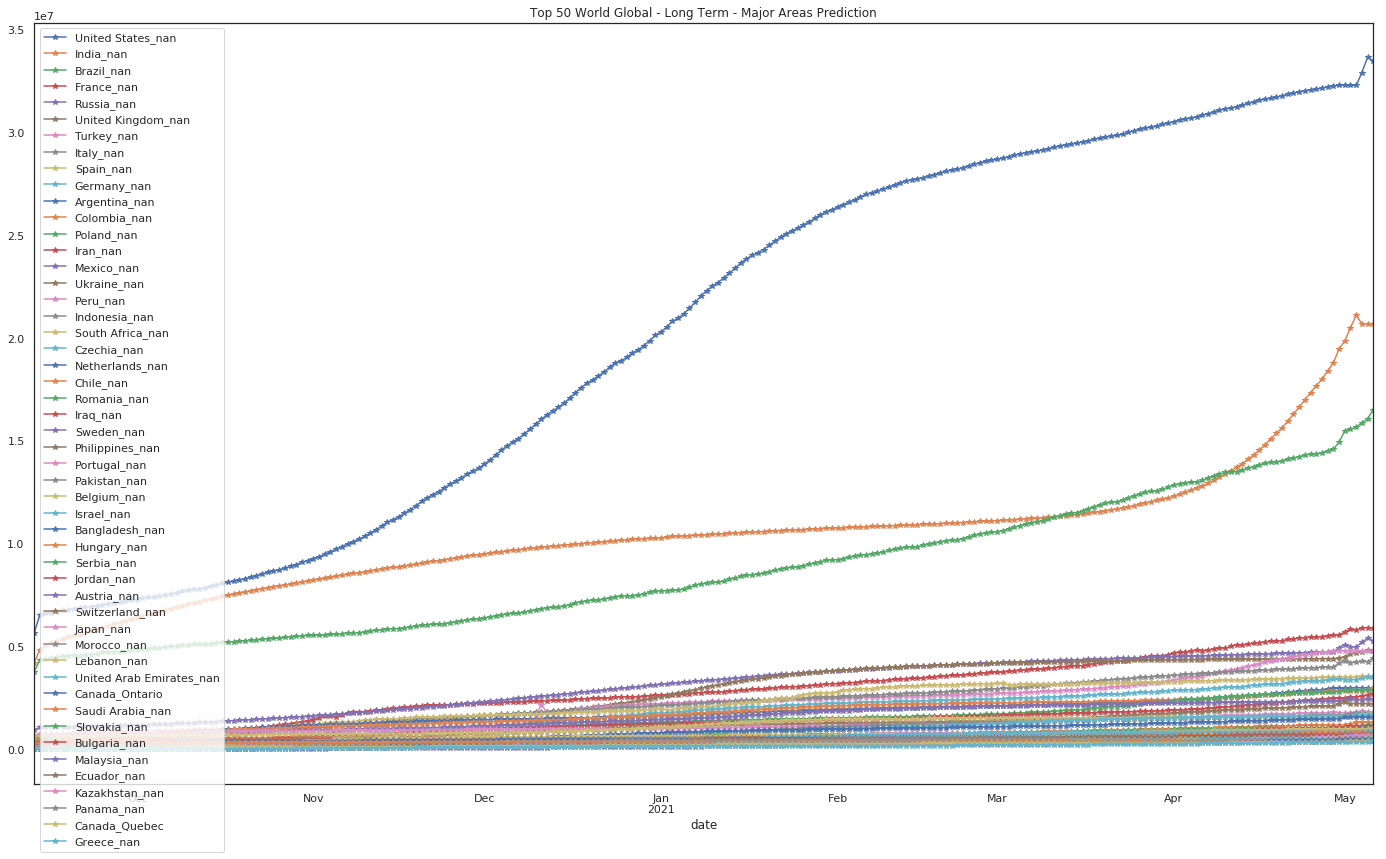

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

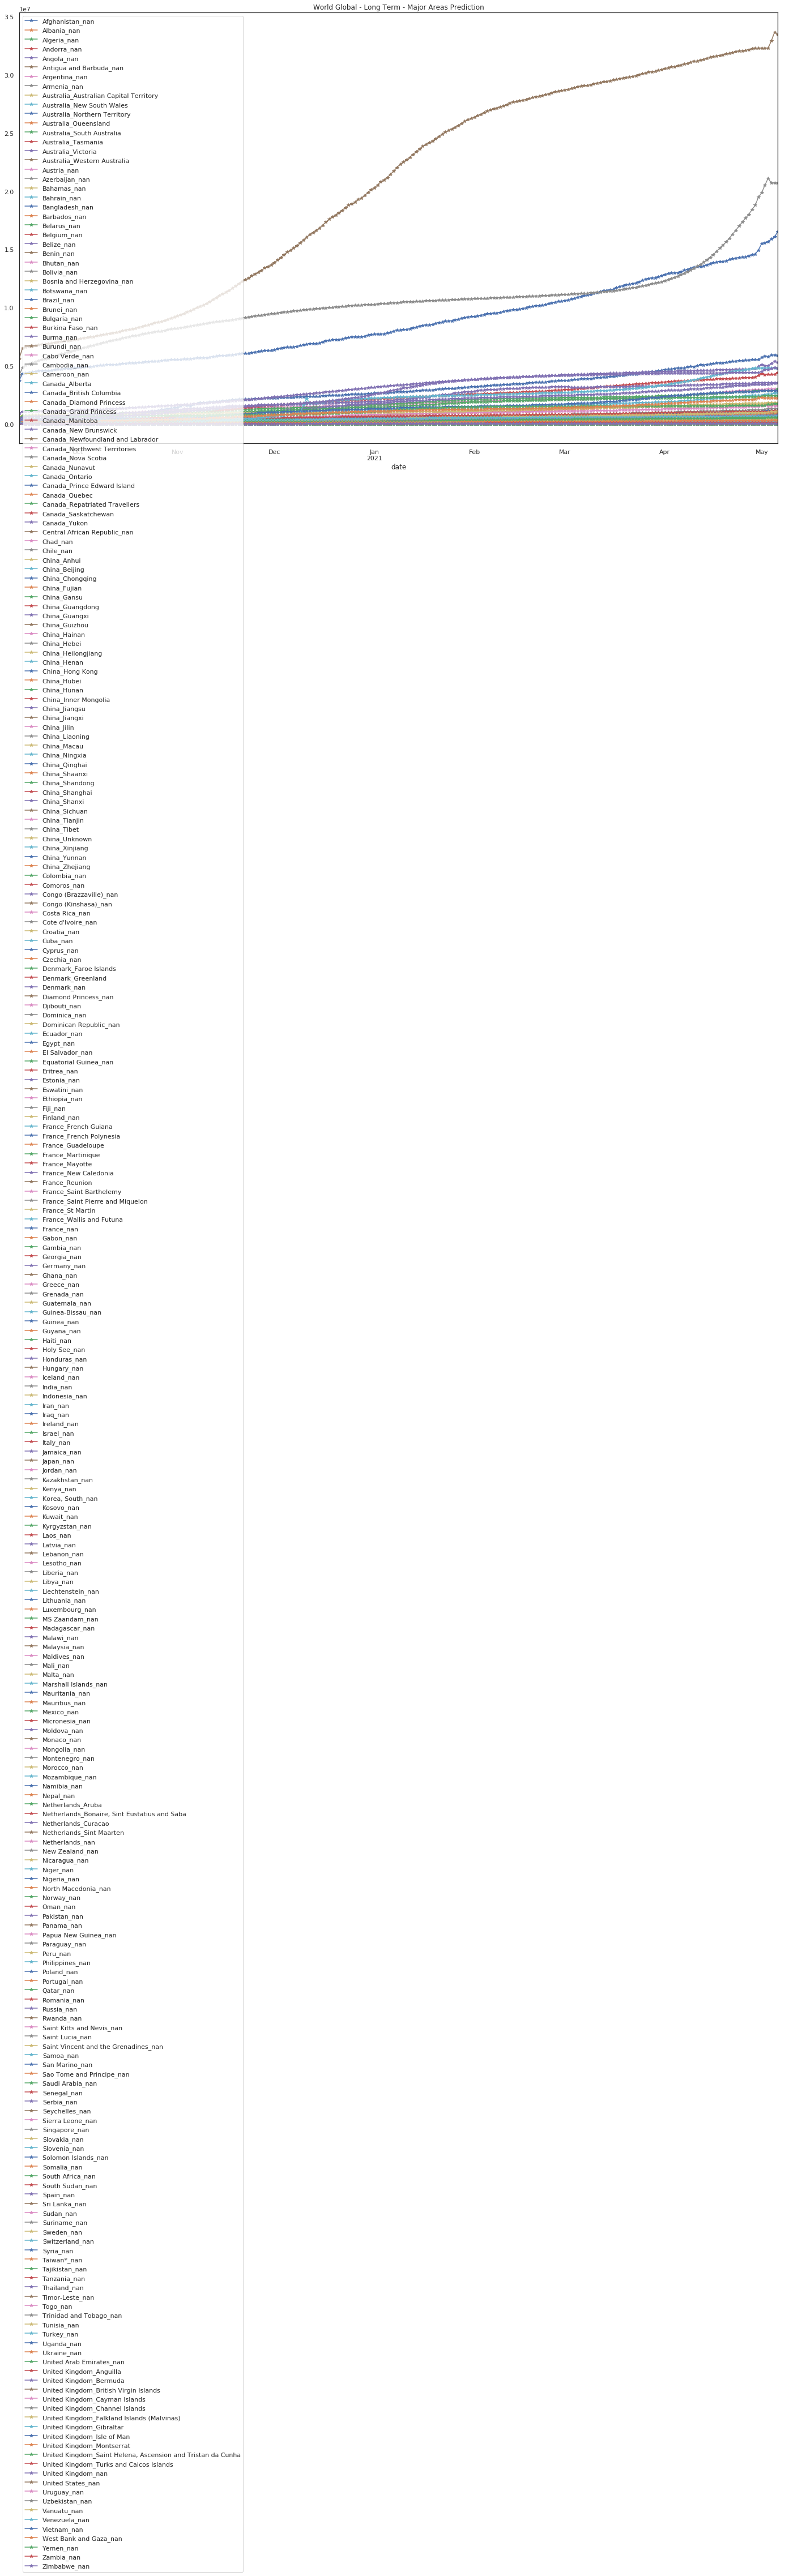

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-10-28          41221.0      19974.0      57083.0       4410.0   
2020-10-29          41349.0      20243.0      57397.0       4517.0   
2020-10-30          41425.0      20575.0      57713.0       4567.0   
2020-10-31          41508.0      20812.0      58010.0       4665.0   
2020-11-01          41584.0      21158.0      58326.0       4756.0   
2020-11-02          41702.0      21448.0      58636.0       4825.0   
2020-11-03          41809.0      21825.0      59020.0       4888.0   
2020-11-04          41896.0      22211.0      59568.0       4910.0   
2020-11-05          42014.0      22632.0      60227.0       5045.0   
2020-11-06          42065.0      23112.0      60886.0       5135.0   
2020-11-07          42115.0      23592.0      61475.0       5257.0   
2020-11-08          42231.0      24097.0      62111.0       5319.0   
2020-11-09          42367.0      24624.0      62756.0       5383.0   
2020-11-10          42539.0      25174.0      63471.0       5437.0   
2020-11-11          42695.0      25682.0      64290.0       5477.0   
2020-11-12          42874.0      26123.0      65144.0       5567.0   
2020-11-13          43052.0      26617.0      66024.0       5616.0   
2020-11-14          43126.0      27114.0      66872.0       5725.0   
2020-11-15          43299.0      27696.0      67715.0       5746.0   
2020-11-16          43527.0      28305.0      68612.0       5872.0   
2020-11-17          43743.0      29000.0      69601.0       5914.0   
2020-11-18          43994.0      29708.0      70654.0       5951.0   
2020-11-19          44245.0      30491.0      71690.0       6018.0   
2020-11-20          44440.0      31317.0      72781.0       6066.0   
2020-11-21          44580.0      32067.0      73825.0       6142.0   
2020-11-22          44758.0      32670.0      74875.0       6207.0   
2020-11-23          45027.0      33434.0      75901.0       6256.0   
2020-11-24          45237.0      34146.0      76985.0       6304.0   
2020-11-25          45445.0      34812.0      78058.0       6351.0   
2020-11-26          45664.0      35492.0      79107.0       6428.0   
...                     ...          ...          ...          ...   
2021-04-07          56956.0     127030.0     118077.0      12328.0   
2021-04-08          57034.0     127382.0     118189.0      12363.0   
2021-04-09          57108.0     127699.0     118316.0      12409.0   
2021-04-10          57227.0     128051.0     118450.0      12456.0   
2021-04-11          57262.0     128337.0     118582.0      12497.0   
2021-04-12          57318.0     128437.0     118716.0      12545.0   
2021-04-13          57442.0     128613.0     118862.0      12581.0   
2021-04-14          57572.0     128846.0     119044.0      12614.0   
2021-04-15          57634.0     129012.0     119219.0      12641.0   
2021-04-16          57692.0     129189.0     119395.0      12641.0   
2021-04-17          57798.0     129348.0     119564.0      12712.0   
2021-04-18          57880.0     129486.0     119712.0      12771.0   
2021-04-19          57974.0     129594.0     119869.0      12805.0   
2021-04-20          58114.0     129715.0     120052.0      12805.0   
2021-04-21          58293.0     129876.0     120242.0      12874.0   
2021-04-22          58414.0     130011.0     120430.0      12917.0   
2021-04-23          58610.0     130167.0     120631.0      12942.0   
2021-04-24          58823.0     130318.0     120811.0      13007.0   
2021-04-25          58936.0     130442.0     120986.0      13024.0   
2021-04-26          59087.0     130537.0     121177.0      13060.0   
2021-04-27          59292.0     130612.0     121402.0      13083.0   
2021-04-28          59450.0     130757.0     121653.0      13121.0   
2021-04-29          59642.0     130874.0     121934.0      13148.0   
2021-04-30          60651.0     134584.0     121991.0      13198.0   
2021-05-01

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
251                                    Timor-Leste_nan  -8.874217  125.727539   
252                                           Togo_nan   8.619500    0.824800   
253                            Trinidad and Tobago_nan  10.691800  -61.222500   
254                                        Tunisia_nan  33.886917    9.537499   
255                                         Turkey_nan  38.963700   35.243300   
256                                  United States_nan  40.000000 -100.000000   
257                                         Uganda_nan   1.373333   32.290275   
258                                        Ukraine_nan  48.379400   31.165600   
259                           United Arab Emirates_nan  23.424076   53.847818   
260                            United Kingdom_Anguilla  18.220600  -63.068600   
261                             United Kingdom_Bermuda  32.307800  -64.750500   
262              United Kingdom_British Virgin Islands  18.420700  -64.640000   
263                      United Kingdom_Cayman Islands  19.313300  -81.254600   
264                     United Kingdom_Channel Islands  49.372300   -2.364400   
265         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
266                           United Kingdom_Gibraltar  36.140800   -5.353600   
267                         United Kingdom_Isle of Man  54.236100   -4.548100   
268                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      23               Belgium_nan  50.833300    4.469936   
4      30                Brazil_nan -14.235000  -51.925300   
5      32              Bulgaria_nan  42.733900   25.485800   
6      51            Canada_Ontario  51.253800  -85.323200   
7      53             Canada_Quebec  52.939900  -73.549100   
8      59                 Chile_nan -35.675100  -71.543000   
9      94              Colombia_nan   4.570900  -74.297300   
10    103               Czechia_nan  49.817500   15.473000   
11    111               Ecuador_nan  -1.831200  -78.183400   
12    132                France_nan  46.227600    2.213700   
13    137               Germany_nan  51.165691   10.451526   
14    139                Greece_nan  39.074200   21.824300   
15    149               Hungary_nan  47.162500   19.503300   
16    151                 India_nan  20.593684   78.962880   
17    152             Indonesia_nan  -0.789300  113.921300   
18    153                  Iran_nan  32.427908   53.688046   
19    154                  Iraq_nan  33.223191   43.679291   
20    156                Israel_nan  31.046051   34.851612   
21    157                Israel_nan  31.046051   34.851612   
22    158                 Italy_nan  41.871940   12.567380   
23    160                 Japan_nan  36.204824  138.252924   
24    161                Jordan_nan  31.240000   36.510000   
25    162            Kazakhstan_nan  48.019600   66.923700   
26    170               Lebanon_nan  33.854700   35.862300   
27    171               Lebanon_nan  33.854700   35.862300   
28    181              Malaysia_nan   4.210484  101.975766   
29    188                Mexico_nan  23.634500 -102.552800   
30    194               Morocco_nan  31.791700   -7.092600   
31    202           Netherlands_nan  52.132600    5.291300   
32    210              Pakistan_nan  30.375300   69.345100   
33    211                Panama_nan   8.538000  -80.782100   
34    214                  Peru_nan  -9.190000  -75.015200   
35    215           Philippines_nan  12.879721  121.774017   
36    216                Poland_nan  51.919400   19.145100   
37    217              Portugal_nan  39.399900   -8.224500   
38    219               Romania_nan  45.943200   24.966800   
39    220                Russia_nan  61.524010  105.318756   
40    228          Saudi Arabia_nan  23.885942   45.079162   
41    230                Serbia_nan  44.016500   21.005900   
42    234              Slovakia_nan  48.669000   19.699000   
43    238          South Africa_nan -30.559500   22.937500   
44    240                 Spain_nan  40.463667   -3.749220   
45    244                Sweden_nan  60.128161   18.643501   
46    245           Switzerland_nan  46.818200    8.227500   
47    255                Turkey_nan  38.963700   35.243300   
48    256         United States_nan  40.000000 -100.000000   
49    258               Ukraine_nan  48.379400   31.165600   
50    259  United Arab Emirates_nan  23.424076   53.847818   
51    271        United Kingdom_nan  55.378100   -3.436000   

    2020-09-13 00:00:00  2020-09-14 00:00:00  2020-09-15 00:00:00  \
0              497060.0             555537.0             578062.0   
1               46505.0              46834.0              33541.0   
2              309018.0             337520.0             339490.0   
3               98510.0              99244.0              94306.0   
4             3752959.0            4330455.0            4381250.0   
5               33359.0              33482.0              18061.0   
6               57998.0              58361.0              46905.0   
7               73956.0              74194.0              65262.0   
8              392878.0             434748.0             436433.0   
9              635736.0    

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()

In [94]:
num_days_R_prediction=14
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)
print(str(ndaysavg)+' '+str(ndayarray)+' '+str(n2dayarray))

14 -17 -31
